In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns

from dotenv import load_dotenv
from functools import reduce
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor, plot_importance

%matplotlib inline
plt.style.use("ggplot")
sns.set_context("talk")

Using TensorFlow backend.


In [2]:
load_dotenv("")
FREDkey = os.getenv("FREDkey")

In [3]:
varlist = ["WILL5000INDFC",
           "NIKKEI225",
           "CPIAUCSL",
           "CPIFABSL",
           "CPIHOSSL",
           "IC4WSA",
           "INDPRO",
           "IPMAN",
           "HOUST",
           "HSN1F",
           "RELACBW027SBOG",
           "MSPNHSUS",
           "USSTHPI",
           "AHETPI",
           "PCE",
           "PCEND",
           "DAUTOSAAR",
           "PI",
           "A229RX0",
           "DEXJPUS",
           "DTWEXM",
           "DGS30",
           "DGS10",
           "DGS2",
           "DGS5",
           "DTB3",
           "MORTGAGE30US",
           "AAA",
           "BAA",
           "BAMLCC0A0CMTRIV",
           "FEDFUNDS",
           "TB3SMFFM",
           "UMCSENT",  
           "CIVPART",
           "TCU",
           "UNRATE",
           "LNS14000002",
           "LNS15000000",
           "UEMPMEAN",
           "USCONS",
           "NFCI",
           "USRECDM",
           "GDPPOT",
           "GDPC1",
           "GOLDPMGBD228NLBM",
           "WTISPLC",
           "CMRMTSPL",
           "TERMCBAUTO48NS",
           "TERMCBPER24NS",
           "NONREVSL",
           "CEFDFSA066MSFRBPHI",
           "M1SL",
           "MABMM301USM189S",
           "TOTALSA",
           "PSAVERT",
           "TOTCI",
           "TOTLL",
           "TOTBKCR",
           "DPRIME",
           "MSACSR",
           "PPIACO",
           "PERMIT",
           "DSPIC96",
           "TLAACBW027SBOG",
           "M12MTVUSM227NFWA",
           "AWHMAN",
           "CCSA",
           "TCD",
           "CSCICP03USM665S"
          ]

In [4]:
datalist=[]
for var in varlist:
    resp = requests.get(
        "https://api.stlouisfed.org/fred/series/observations?series_id={}&api_key={}&file_type=json"
        .format(var, 
                FREDkey))
    df = pd.DataFrame(resp.json()['observations'])
    df.date = pd.to_datetime(df.date)
    df = df.loc[df.value!="."]
    df.value = df.value.astype(float)
    df.index = df.date
    df.drop(columns=["realtime_end", "realtime_start", "date"], axis=1, inplace=True)
    df.columns=[var]
    df= df.resample("1D").interpolate(method='linear')
    datalist.append(df)

In [5]:
df_merged = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), datalist)

In [6]:
df_merged.shape

(63858, 69)

In [7]:
df_merged["2-10"] = df_merged.DGS10 - df_merged.DGS2
df_merged["10-30"] = df_merged.DGS30 - df_merged.DGS10
df_merged["positive_gap"] = df_merged.GDPC1.pct_change(365) - df_merged.GDPPOT.pct_change(365) > 0
df_merged["gap"] = df_merged.GDPC1.pct_change(365) - df_merged.GDPPOT.pct_change(365)
df_WILL5000_5d_vol = df_merged.WILL5000INDFC.pct_change(1).rolling(5).std()
df_WILL5000_30d_vol = df_merged.WILL5000INDFC.pct_change(1).rolling(30).std()

In [8]:
df_WILL5000_5d_vol= df_WILL5000_5d_vol.loc[df_merged.DGS30>-10].resample("1W").mean()
df_WILL5000_30d_vol= df_WILL5000_30d_vol.loc[df_merged.DGS30>-10].resample("1W").mean()
df_merged = df_merged.loc[df_merged.DGS30>-10].resample("1W").mean()

In [9]:
percent = ["WILL5000INDFC",
           "NIKKEI225",
           "CPIAUCSL", 
           "CPIFABSL",
           "CPIHOSSL",
           "IC4WSA",
           "INDPRO",
           "IPMAN",
           "HOUST",
           "HSN1F",
           "RELACBW027SBOG",
           "MSPNHSUS",
           "USSTHPI",
           "AHETPI",
           "PCE",
           "PCEND",
           "DAUTOSAAR",
           "A229RX0",
           "DEXJPUS",
           "DTWEXM",
           "GOLDPMGBD228NLBM",
           "WTISPLC",
           "BAMLCC0A0CMTRIV",
           "CMRMTSPL",
           "NONREVSL",
           "M1SL",
           "MABMM301USM189S",
           "TOTALSA",
           "TOTCI",
           "TOTLL",
           "TOTBKCR",
           "PPIACO",
           "PERMIT",
           "DSPIC96",
           "TLAACBW027SBOG",
           "M12MTVUSM227NFWA",
           "PI",
           "AWHMAN",
           "CCSA",
           "TCD",
           "UEMPMEAN",
           "LNS15000000",
           "USCONS"
          ]

In [10]:
actual = ["DGS30",
          "DGS10",
          "DGS2",
          "DGS5",
          "DTB3",
          "MORTGAGE30US",
          "AAA",
          "BAA",
          "FEDFUNDS",
          "TB3SMFFM",
          "UMCSENT",  
          "CIVPART",
          "TCU",
          "UNRATE",
          "LNS14000002",
          "NFCI",
          "2-10",
          "10-30",
          "gap",
          "TERMCBAUTO48NS",
          "TERMCBPER24NS",
          "CEFDFSA066MSFRBPHI",
          "PSAVERT",
          "DPRIME",
          "MSACSR",
          "CSCICP03USM665S"
         ]

In [11]:
def change(df, percent, actual, period):
    df_actual = df[actual].diff(period).fillna(method='ffill')

    df_percent = df[percent].pct_change(period).fillna(method='ffill')
    df_concat = pd.concat([df_actual, df_percent], axis=1)
    df_concat.columns = [str(col) + '_{}'.format(period) for col in df_concat.columns]
    return df_concat

In [12]:
week = change(df_merged, percent, actual, 1)
week_week = week.diff(1).add_suffix("_1")
month = change(df_merged, percent, actual, 4)
month_month = month.diff(4).add_suffix("_4")
three_m = change(df_merged, percent, actual, 13)
three_three = three_m.diff(13).add_suffix("_13")
six_m = change(df_merged, percent, actual, 26)
six_six = six_m.diff(26).add_suffix("_26")
one_y = change(df_merged, percent, actual, 52)

In [13]:
X = pd.concat([week, 
               week_week, 
               month, 
               month_month, 
               three_m, 
               three_three, 
               six_m, 
               six_six, 
               one_y,
               df_merged[actual].fillna(method="ffill"),
               df_merged[actual].fillna(method="ffill").shift(1),
               df_merged[actual].fillna(method="ffill").shift(4),
               df_merged[actual].fillna(method="ffill").shift(13),
               df_merged[actual].fillna(method="ffill").shift(26),
               df_merged[actual].fillna(method="ffill").shift(52),
               df_WILL5000_5d_vol,
               df_WILL5000_30d_vol
              ], axis=1)[52:]

In [14]:
# X = pd.concat([week, 
#                week_week, 
#                month, 
#                month_month, 
#                three_m, 
#                three_three, 
#                six_m, 
#                six_six, 
#                one_y,
#               ], axis=1)[52:]

In [15]:
y1w = df_merged.positive_gap.shift(-1)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y1m = df_merged.positive_gap.shift(-4)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y3m = df_merged.positive_gap.shift(-13)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y6m = df_merged.positive_gap.shift(-26)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
y12m = df_merged.positive_gap.shift(-52)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)

In [16]:
# GDPC1y1w = df_merged.USREC.shift(-1)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y1m = df_merged.USREC.shift(-4)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y3m = df_merged.USREC.shift(-13)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y6m = df_merged.USREC.shift(-26)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)
# y12m = df_merged.USREC.shift(-52)[X.index].fillna(method="ffill").apply(lambda x: 1 if x>0.5 else 0)

In [17]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [18]:
X.isnull().sum().sort_values(ascending=False)

WILL5000INDFC             0
RELACBW027SBOG_4_4        0
PERMIT_4_4                0
PPIACO_4_4                0
TOTBKCR_4_4               0
TOTLL_4_4                 0
TOTCI_4_4                 0
TOTALSA_4_4               0
MABMM301USM189S_4_4       0
M1SL_4_4                  0
NONREVSL_4_4              0
CMRMTSPL_4_4              0
BAMLCC0A0CMTRIV_4_4       0
WTISPLC_4_4               0
GOLDPMGBD228NLBM_4_4      0
DTWEXM_4_4                0
DEXJPUS_4_4               0
A229RX0_4_4               0
DAUTOSAAR_4_4             0
PCEND_4_4                 0
PCE_4_4                   0
AHETPI_4_4                0
USSTHPI_4_4               0
DSPIC96_4_4               0
TLAACBW027SBOG_4_4        0
M12MTVUSM227NFWA_4_4      0
DTB3_13                   0
UNRATE_13                 0
TCU_13                    0
CIVPART_13                0
                         ..
UMCSENT_26_26             0
TB3SMFFM_26_26            0
FEDFUNDS_26_26            0
BAA_26_26                 0
AAA_26_26           

In [19]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

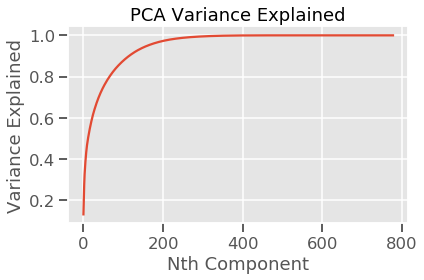

In [20]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title("PCA Variance Explained")
plt.xlabel("Nth Component")
plt.ylabel("Variance Explained")
plt.tight_layout()
plt.savefig("../images/pca")

In [21]:
n_pc = 150

In [22]:
X_train = X_pca[:int(X_pca.shape[0]*0.7), :n_pc]
X_test = X_pca[int(X_pca.shape[0]*0.7):, :n_pc]

In [23]:
X_train.shape

(1521, 150)

In [24]:
y1w.shape

(2173,)

In [25]:
y1w_train = y1w[:int(X_pca.shape[0]*0.7)]
y1w_test = y1w[int(X_pca.shape[0]*0.7):]

In [26]:
clf = SVC(C=0.1, gamma=0.001, probability=True)
clf.fit(X_train, y1w_train)
confusion_matrix(clf.predict(X_test), y1w_test)

array([[121,  27],
       [107, 397]])

In [27]:
clf.score(X_train, y1w_train)

0.8974358974358975

In [28]:
clf.score(X_test, y1w_test)

0.7944785276073619

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


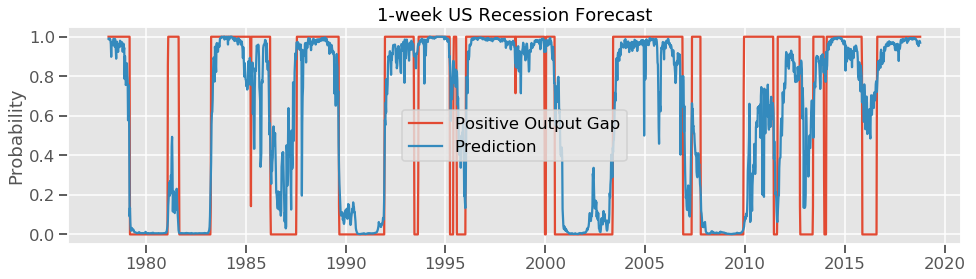

In [29]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("1-week US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/1w_gap_svc")
plt.show()

In [30]:
y1m_train = y1m[:int(X_pca.shape[0]*0.7)]
y1m_test = y1m[int(X_pca.shape[0]*0.7):]

In [31]:
clf = SVC(C=20, gamma=0.00001, probability=True)
clf.fit(X_train, y1m_train)
print(confusion_matrix(clf.predict(X_test), y1m_test))
print("train:", clf.score(X_train, y1m_train))
print("test", clf.score(X_test, y1m_test))

[[123  37]
 [106 386]]
train: 0.9513477975016437
test 0.7806748466257669


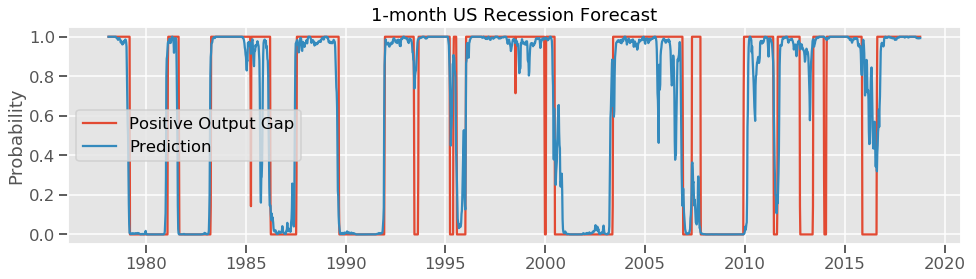

In [32]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("1-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/1m_gap_svc")
plt.show()

In [33]:
y3m_train = y3m[:int(X_pca.shape[0]*0.7)]
y3m_test = y3m[int(X_pca.shape[0]*0.7):]

In [34]:
clf = SVC(C=20, gamma=0.00001, probability=True)
clf.fit(X_train, y3m_train)
print(confusion_matrix(clf.predict(X_test), y3m_test))
print("train:", clf.score(X_train, y3m_train))
print("test", clf.score(X_test, y3m_test))

[[110  12]
 [128 402]]
train: 0.9546351084812623
test 0.7852760736196319


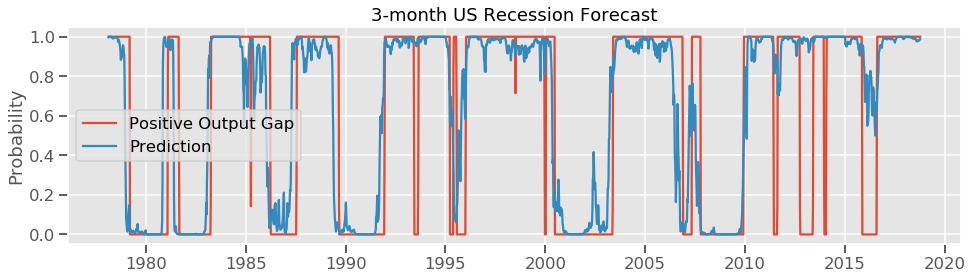

In [35]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("3-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/3m_gap_svc")
plt.show()

In [36]:
clf = RandomForestClassifier(max_features=120, 
                             n_estimators=60, 
                             max_depth=8, 
                             min_samples_leaf=100, 
                             random_state=0,
                             class_weight="balanced"
                            )
clf.fit(X_train, y3m_train)
print(confusion_matrix(clf.predict(X_test), y3m_test))
print("train:", clf.score(X_train, y3m_train))
print("test", clf.score(X_test, y3m_test))

[[225 226]
 [ 13 188]]
train: 0.8211702827087443
test 0.6334355828220859


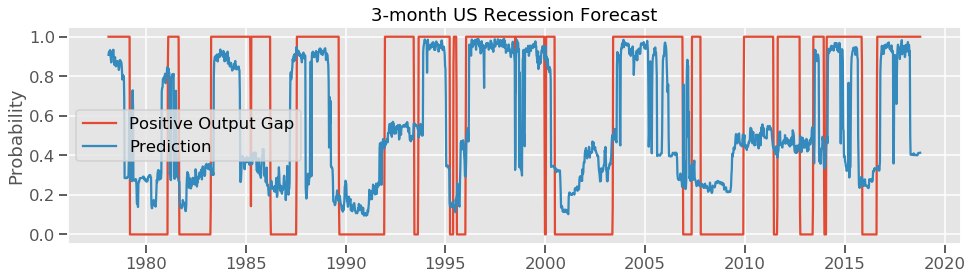

In [37]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("3-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/3m_gap_rfc")
plt.show()

In [38]:
y6m_train = y6m[:int(X_pca.shape[0]*0.7)]
y6m_test = y6m[int(X_pca.shape[0]*0.7):]

In [39]:
clf = SVC(C=35,
          gamma=0.00001,
          probability=True)
clf.fit(X_train, y6m_train)
print(confusion_matrix(clf.predict(X_test), y6m_test))
print(clf.score(X_train, y6m_train))
print(clf.score(X_test, y6m_test))

[[ 75   4]
 [176 397]]
0.9493754109138725
0.7239263803680982


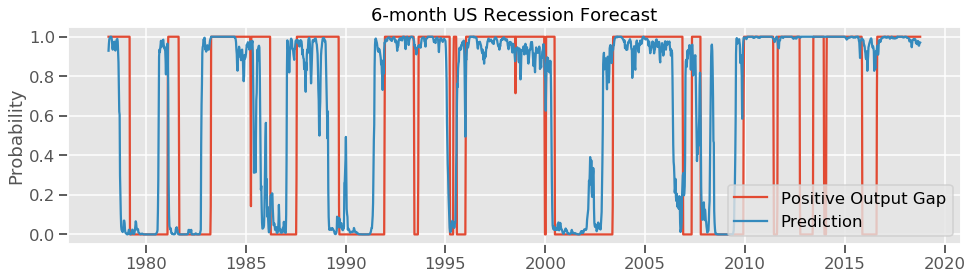

In [40]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/6m_gap_svc")
plt.show()

In [41]:
clf = RandomForestClassifier(max_features=100, 
                             n_estimators=30, 
                             max_depth=8, 
                             min_samples_leaf=100, 
                             random_state=0,
                             class_weight="balanced"
                            )
clf.fit(X_train, y6m_train)
print(confusion_matrix(clf.predict(X_test), y6m_test))
print(clf.score(X_train, y6m_train))
print(clf.score(X_test, y6m_test))

[[153  35]
 [ 98 366]]
0.8270874424720579
0.7960122699386503


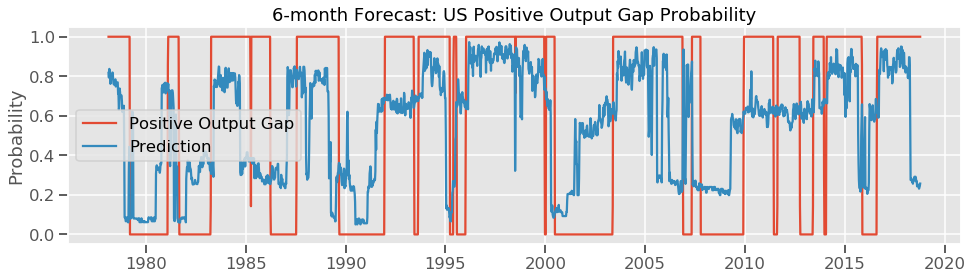

In [42]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month Forecast: US Positive Output Gap Probability")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=0)
plt.savefig("../images/6m_gap_rfc")
plt.show()

In [43]:
y12m_train = y12m[:int(X_pca.shape[0]*0.7)]
y12m_test = y12m[int(X_pca.shape[0]*0.7):]

[[ 29  20]
 [222 381]]
0.8474687705456936
0.6288343558282209


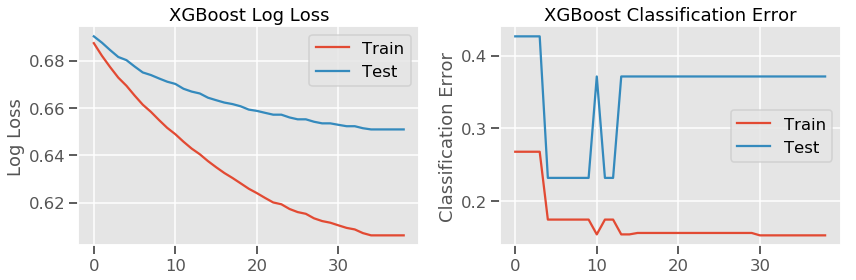

In [44]:
clf = XGBClassifier(max_depth=2, 
                    learning_rate=0.1, 
                    n_estimators=200,
                    gamma=1,
                    random_state=0,
                    scale_pos_weight=y6m_train.value_counts()[0]/y6m_train.value_counts()[1],
                    reg_alpha=100,
                    reg_lambda=100
                   )
clf.fit(X_train, 
        y6m_train, 
        eval_set = [(X_train, y6m_train), (X_test, y6m_test)],
        eval_metric=["error", "logloss"],
        early_stopping_rounds=5, 
        verbose=False
       )
print(confusion_matrix(clf.predict(X_test), y6m_test))
print(clf.score(X_train, y6m_train))
print(clf.score(X_test, y6m_test))

# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(x_axis, results['validation_0']['logloss'], label='Train')
ax[0].plot(x_axis, results['validation_1']['logloss'], label='Test')
ax[0].legend()
ax[0].set_ylabel('Log Loss')
ax[0].set_title('XGBoost Log Loss')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_ylabel('Classification Error')
ax[1].set_title('XGBoost Classification Error')
plt.tight_layout()
plt.show()

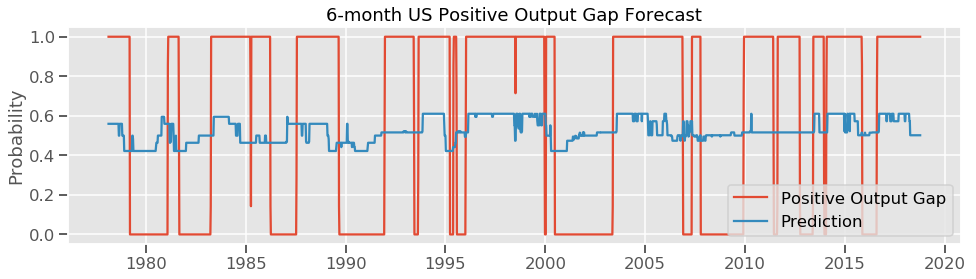

In [45]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Positive Output Gap Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/6m_gap_xgc")
plt.show()

In [46]:
xgc_scores = {}
xgc_feature_sets = []
k=0
for i in range(0, 100, 10):
    for j in range(0, 100, 10):
        xgc = XGBClassifier(reg_alpha=i, reg_lambda=j)
        xgc.fit(X_train,
                y6m_train,
                eval_set = [(X_train, y6m_train), (X_test, y6m_test)],
                eval_metric=["error", "logloss"],
                early_stopping_rounds=5,
                verbose=False)

        
        xgc_features = pd.DataFrame(xgc.feature_importances_, 
                                    columns=["importance"]
                                   ).sort_values(by="importance",
                                                 ascending=False) 
                                
        xgc_scores[k] = [i,
                         j,
                         clf.evals_result()['validation_0']['logloss'][-1],
                         clf.evals_result()['validation_1']['logloss'][-1],
                         clf.evals_result()['validation_0']['error'][-1],
                         clf.evals_result()['validation_1']['error'][-1],
                         np.sum(xgc_features.importance>0)]
        xgc_feature_sets.append(xgc_features)
        k += 1
        if k%10 ==0:
            print("Progress: {}% completed".format(k))

Progress: 10% completed
Progress: 20% completed
Progress: 30% completed
Progress: 40% completed
Progress: 50% completed
Progress: 60% completed
Progress: 70% completed
Progress: 80% completed
Progress: 90% completed
Progress: 100% completed


In [47]:
xgc_reg_score = pd.DataFrame(xgc_scores, 
                             index=["alpha",
                                    "lambda",
                                    "train_log_loss",
                                    "test_log_loss",
                                    "train_error",
                                    "test_error",
                                    "n_features"
                                   ]).T

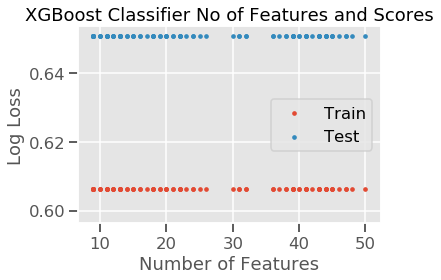

In [48]:
plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train_log_loss,
            s=10
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test_log_loss,
            s=10
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Log Loss")
plt.xlabel("Number of Features")
plt.legend(["Train","Test"])
plt.tight_layout()
plt.savefig("../images/output_gap_xgc_reg_log_loss_6m")

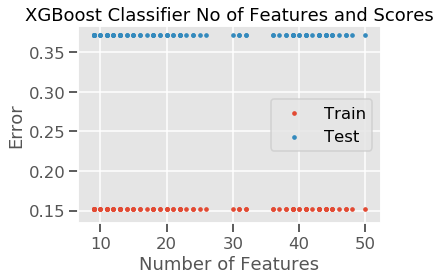

In [49]:
plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train_error,
            s=10
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test_error,
            s=10
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Error")
plt.xlabel("Number of Features")
plt.legend(["Train","Test"])
plt.tight_layout()
plt.savefig("../images/output_gap_xgc_reg_error_6m")

In [50]:
y12m_train = y12m[:int(X_pca.shape[0]*0.7)]
y12m_test = y12m[int(X_pca.shape[0]*0.7):]

In [51]:
clf = SVC(C=100, 
          gamma=0.000005, 
          probability=True,
          random_state=0,
          class_weight="balanced"
         )
clf.fit(X_train, y12m_train)
print(confusion_matrix(clf.predict(X_test), y12m_test))
print("train:", clf.score(X_train, y12m_train))
print("test:", clf.score(X_test, y12m_test))

[[108  29]
 [143 372]]
train: 0.9263642340565418
test: 0.7361963190184049


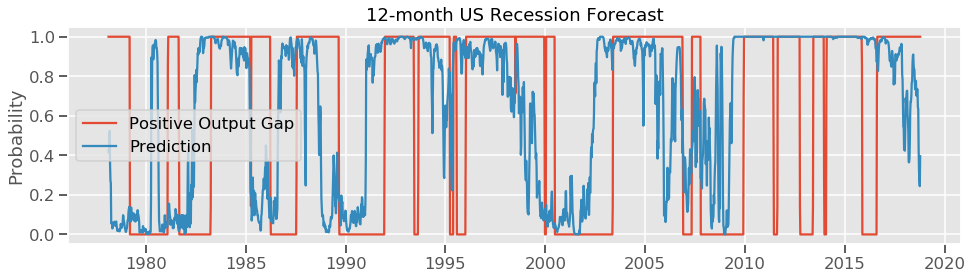

In [52]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_svc")
plt.show()

In [53]:
y12m_train.value_counts()[1]/y12m_train.value_counts()[0]

1.4532258064516128

In [54]:
clf = RandomForestClassifier(max_features=100, 
                             n_estimators=70, 
                             max_depth=30, 
                             min_samples_leaf=50,
                             random_state=0, 
                             class_weight="balanced"
                            )
clf.fit(X_train, 
        y12m_train)
print(confusion_matrix(clf.predict(X_test), y12m_test))
print("train:", clf.score(X_train, y12m_train))
print("test:", clf.score(X_test, y12m_test))

[[125  21]
 [126 380]]
train: 0.8783694937541091
test: 0.7745398773006135


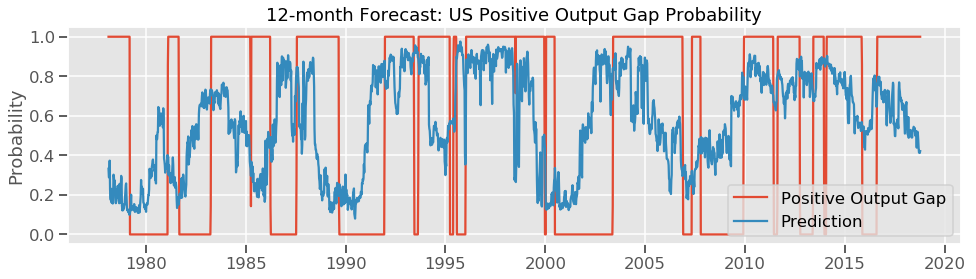

In [55]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month Forecast: US Positive Output Gap Probability")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/12m_gap_rfc")
plt.show()

[[ 84   0]
 [167 401]]
train: 0.7738330046022354
test: 0.7438650306748467


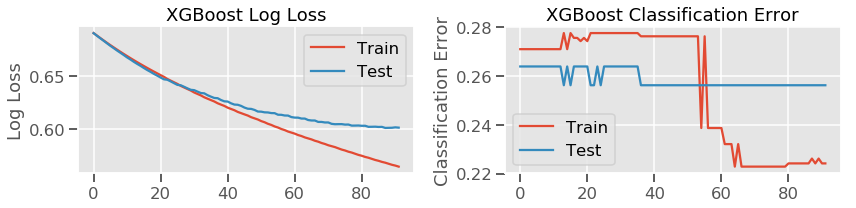

In [56]:
clf = XGBClassifier(max_depth=2, 
                    learning_rate=0.01, 
                    n_estimators=200,
                    gamma=1,
                    scale_pos_weight=y6m_train.value_counts()[0]/y6m_train.value_counts()[1]
                   )
clf.fit(X_train, 
        y12m_train, 
        eval_set = [(X_train, y12m_train), (X_test, y12m_test)],
        eval_metric=["error", "logloss"],
        early_stopping_rounds=5,
        verbose=False
       )
print(confusion_matrix(clf.predict(X_test), y12m_test))
print("train:", clf.score(X_train, y12m_train))
print("test:", clf.score(X_test, y12m_test))

# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax[0].plot(x_axis, results['validation_0']['logloss'], label='Train')
ax[0].plot(x_axis, results['validation_1']['logloss'], label='Test')
ax[0].legend()
ax[0].set_ylabel('Log Loss')
ax[0].set_title('XGBoost Log Loss')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_ylabel('Classification Error')
ax[1].set_title('XGBoost Classification Error')
plt.tight_layout()
plt.show()

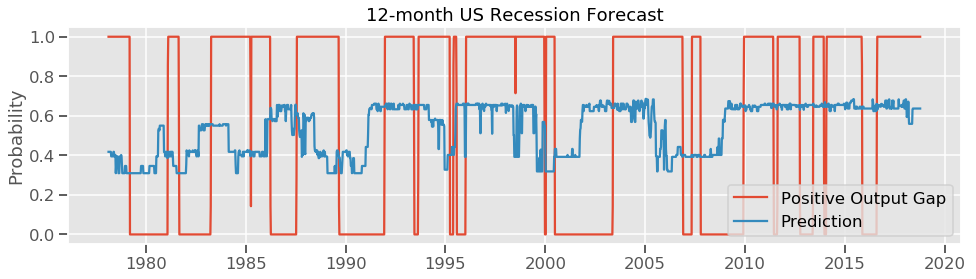

In [57]:
pred = pd.DataFrame(clf.predict_proba(X_pca[:, :n_pc])[:, 1])
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.positive_gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Recession Forecast")
plt.ylabel("Probability")
plt.legend(["Positive Output Gap", "Prediction"], loc=4)
plt.savefig("../images/12m_gap_xgc")
plt.show()

In [58]:
xgc_scores = {}
xgc_feature_sets = []
k=0
for i in range(0, 100, 10):
    for j in range(0, 100, 10):
        xgc = XGBClassifier(reg_alpha=i, reg_lambda=j)
        xgc.fit(X_train, y12m_train)

        
        xgc_features = pd.DataFrame(xgc.feature_importances_, 
                                    columns=["importance"]
                                   ).sort_values(by="importance",
                                                 ascending=False) 
                                
        xgc_scores[k] = [i,
                         j,
                         xgc.score(X_train, y12m_train),
                         xgc.score(X_test, y12m_test),
                         np.sum(xgc_features.importance>0)]
        xgc_feature_sets.append(xgc_features)
        k += 1

In [59]:
xgc_reg_score = pd.DataFrame(xgc_scores, 
                             index=["alpha",
                                    "lambda",
                                    "train",
                                    "test",
                                    "n_features"
                                   ]).T

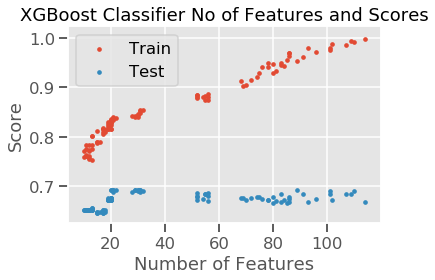

In [60]:
plt.scatter(xgc_reg_score.n_features, 
            xgc_reg_score.train,
            s=10
           )
plt.scatter(xgc_reg_score.n_features,
            xgc_reg_score.test,
            s=10
           )
plt.title("XGBoost Classifier No of Features and Scores")
plt.ylabel("Score")
plt.xlabel("Number of Features")
plt.legend(["Train","Test"])
plt.tight_layout()
plt.savefig("../images/output_gap_xgc_reg_score_12m")

In [61]:
actual = ["DGS30",
          "DGS10",
          "DGS2",
          "DGS5",
          "DTB3",
          "MORTGAGE30US",
          "AAA",
          "BAA",
          "FEDFUNDS",
          "TB3SMFFM",
          "UMCSENT",  
          "CIVPART",
          "TCU",
          "UNRATE",
          "LNS14000002",
          "NFCI",
          "2-10",
          "10-30",
#           "gap",
          "TERMCBAUTO48NS",
          "TERMCBPER24NS",
          "CEFDFSA066MSFRBPHI",
          "PSAVERT",
          "DPRIME",
          "MSACSR",
          "CSCICP03USM665S"
         ]

In [62]:
week = change(df_merged, percent, actual, 1)
week_week = week.diff(1).add_suffix("_1")
month = change(df_merged, percent, actual, 4)
month_month = month.diff(4).add_suffix("_4")
three_m = change(df_merged, percent, actual, 13)
three_three = three_m.diff(13).add_suffix("_13")
six_m = change(df_merged, percent, actual, 26)
six_six = six_m.diff(26).add_suffix("_26")
one_y = change(df_merged, percent, actual, 52)

In [49]:
X = pd.concat([week, 
               week_week, 
               month, 
               month_month, 
               three_m, 
               three_three, 
               six_m, 
               six_six, 
               one_y,
               df_merged[actual].fillna(method="ffill"),
               df_merged[actual].fillna(method="ffill").shift(1),
               df_merged[actual].fillna(method="ffill").shift(4),
               df_merged[actual].fillna(method="ffill").shift(13),
               df_merged[actual].fillna(method="ffill").shift(26),
               df_merged[actual].fillna(method="ffill").shift(52),
               df_WILL5000_5d_vol,
               df_WILL5000_30d_vol
              ], axis=1)[52:]

In [50]:
X_gap = pd.concat([df_merged.gap,
#                    pd.DataFrame(df_merged.gap.diff(1)).add_suffix("_diff"),
#                    pd.DataFrame(df_merged.gap.diff(1).diff(1)).add_suffix("_diff_diff")
                  ], axis=1)[52:]

In [51]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

In [52]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [53]:
X_pca_gap = np.concatenate([np.array(X_gap), X_pca], axis=1)

In [54]:
X_pca_gap.shape

(2174, 780)

In [55]:
n_pc = 150

In [56]:
X_train_gap = X_pca_gap[:int(X_pca.shape[0]*0.7), :n_pc]
X_test_gap = X_pca_gap[int(X_pca.shape[0]*0.7):, :n_pc]

In [57]:
X_train.shape

NameError: name 'X_train' is not defined

In [58]:
g1w = df_merged.gap.shift(-1)[X.index].fillna(method="ffill")
g1m = df_merged.gap.shift(-4)[X.index].fillna(method="ffill")
g3m = df_merged.gap.shift(-13)[X.index].fillna(method="ffill")
g6m = df_merged.gap.shift(-26)[X.index].fillna(method="ffill")
g12m = df_merged.gap.shift(-52)[X.index].fillna(method="ffill")

In [59]:
g6m_train = g6m[:int(X_pca.shape[0]*0.7)]
g6m_test = g6m[int(X_pca.shape[0]*0.7):]
g12m_train = g12m[:int(X_pca.shape[0]*0.7)]
g12m_test = g12m[int(X_pca.shape[0]*0.7):]

In [74]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for c in [np.logspace(-10, 10, 2)]:
#         for e in [np.logspace(-20, 0, 2)]:
#             svm = SVR(C=c, epsilon=e, gamma="auto")
#             svm.fit(X_tr, y_tr)
#             if score < svm.score(X_tst, y_tst):
#                 score_dict[i] = [c, e, svm.score(X_tst, y_tst)]
#     i += 1

In [75]:
svm = SVR(C=50, 
          epsilon=10**-7, 
          gamma="auto")
svm.fit(X_train_gap, g6m_train)
print("train", svm.score(X_train_gap, g6m_train))
print("test", svm.score(X_test_gap, g6m_test))

train 0.9998319466708583
test 0.11739149169396701


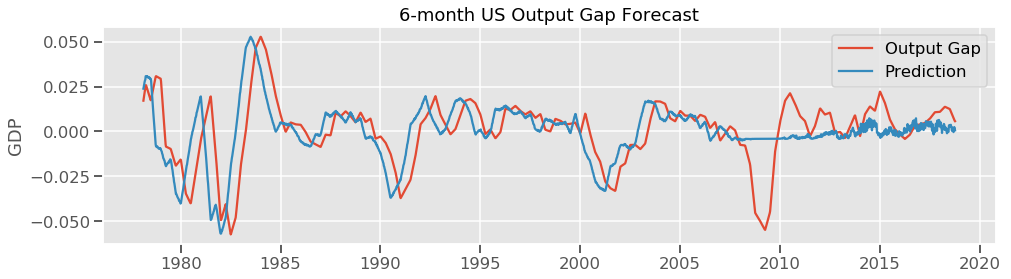

In [76]:
pred = pd.DataFrame(svm.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_svm")
plt.show()

In [77]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for mf in np.linspace(10, 100, 10):
#         for ne in np.linspace(10, 30, 11):
#             for md in np.linspace(5, 25, 11):
#                 for msl in np.linspace(10, 40, 16):
#                     rfr = RandomForestRegressor(max_features=int(mf),
#                                                 n_estimators=int(ne), 
#                                                 max_depth=int(md),
#                                                 min_samples_leaf=int(msl)
#                                                )
#                     rfr.fit(X_tr, y_tr)
#                     if score < rfr.score(X_tst, y_tst):
#                         score_dict[i] = [mf, ne, md, msl, rfr.score(X_tst, y_tst)]
#     i += 1

In [78]:
# score_dict

In [79]:
rfr = RandomForestRegressor(max_features=50,
                            n_estimators=50, 
                            max_depth=20, 
                            min_samples_leaf=30,
                            random_state=0
                           )
rfr.fit(X_train_gap, g6m_train)
print("train: ", rfr.score(X_train_gap, g6m_train))
print("test: ", rfr.score(X_test_gap, g6m_test))

train:  0.8506084181489519
test:  0.6139051558136175


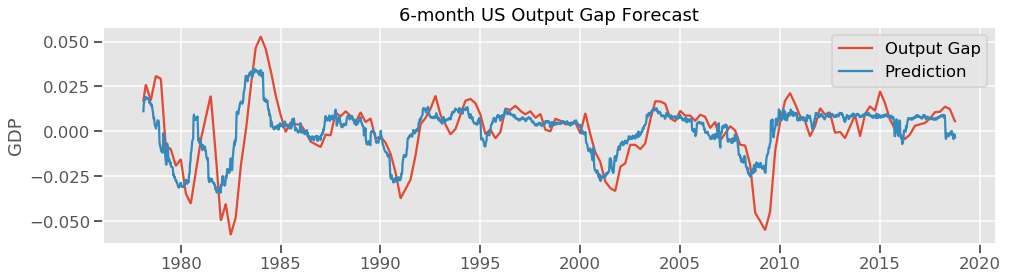

In [80]:
pred = pd.DataFrame(rfr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_rfr")
plt.show()

In [81]:
xgr = XGBRegressor(max_depth=3, 
                   min_child_weight=20,
                   gamma=0,
                   subsample=0.95,
                   colsample_bytree=1,
                   learning_rate=0.3, 
                   n_estimators=200,
                   reg_alpha=0.001,
                   random_state=0
                  )
xgr.fit(X_train_gap,
        g6m_train,
        eval_set=[(X_train_gap, g6m_train), (X_test_gap, g6m_test)],
        early_stopping_rounds=10,
        verbose=False)
print("train", xgr.score(X_train_gap, g6m_train))
print("test", xgr.score(X_test_gap, g6m_test))

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[09:13:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train 0.9495790346948754
test 0.5038748264801646


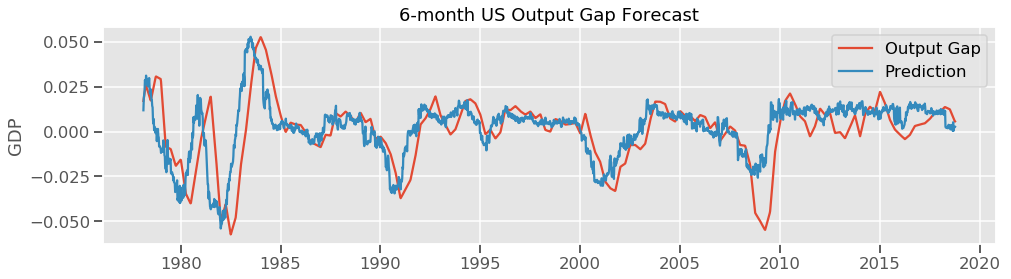

In [82]:
pred = pd.DataFrame(xgr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_xgr")
plt.show()

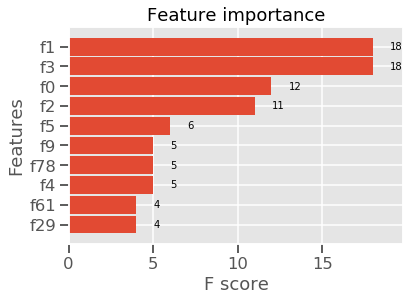

In [83]:
plot_importance(xgr, height=0.9, max_num_features=10)
plt.show()

In [84]:
svm = SVR(C=50, 
          epsilon=10**-7, 
          gamma="auto")
svm.fit(X_train_gap, g12m_train)
print("train", svm.score(X_train_gap, g12m_train))
print("test", svm.score(X_test_gap, g12m_test))

train 0.9998274211418227
test 0.07494834113512283


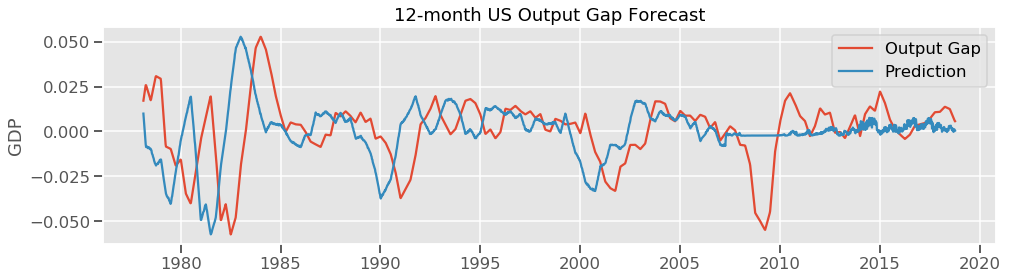

In [85]:
pred = pd.DataFrame(svm.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_svm")
plt.show()

In [86]:
# tscv = TimeSeriesSplit(n_splits=5)
# i = 1
# score_dict = {}
# for train_index, test_index in tscv.split(X_train):
#     X_tr, X_tst = X_train[train_index], X_train[test_index]
#     y_tr, y_tst = g12m_train[train_index], g12m_train[test_index]
#     score = 0
#     for mf in np.linspace(10, 100, 10):
#         for ne in np.linspace(10, 30, 11):
#             for md in np.linspace(5, 25, 11):
#                 for msl in np.linspace(10, 40, 16):
#                     rfr = RandomForestRegressor(max_features=int(mf),
#                                                 n_estimators=int(ne), 
#                                                 max_depth=int(md),
#                                                 min_samples_leaf=int(msl)
#                                                )
#                     rfr.fit(X_tr, y_tr)
#                     if score < rfr.score(X_tst, y_tst):
#                         score_dict[i] = [mf, ne, md, msl, rfr.score(X_tst, y_tst)]
#     i += 1

In [87]:
# score_dict

In [88]:
rfr = RandomForestRegressor(max_features=50,
                            n_estimators=50, 
                            max_depth=20, 
                            min_samples_leaf=30,
                            random_state=0
                           )
rfr.fit(X_train_gap, g12m_train)
print("train: ", rfr.score(X_train_gap, g12m_train))
print("test: ", rfr.score(X_test_gap, g12m_test))

train:  0.7503961897767589
test:  0.21730342507844091


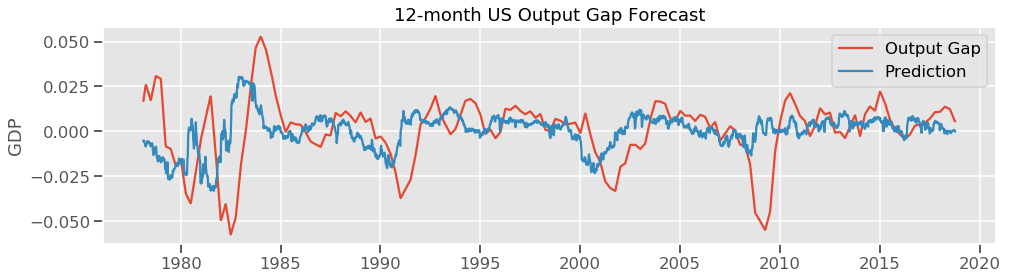

In [89]:
pred = pd.DataFrame(rfr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_rfr")
plt.show()

In [90]:
xgr = XGBRegressor(max_depth=2, 
                   learning_rate=0.13, 
                   n_estimators=40)
xgr.fit(X_train_gap,
        g12m_train)
print("train", xgr.score(X_train_gap, g12m_train))
print("test", xgr.score(X_test_gap, g12m_test))

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[09:14:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train 0.7581930519298301
test 0.07293010866790584


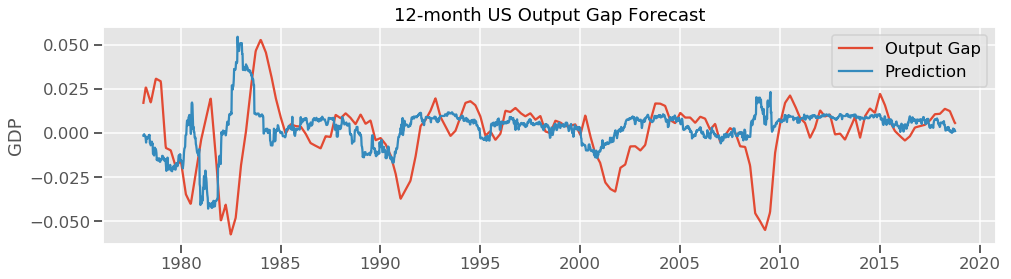

In [91]:
pred = pd.DataFrame(xgr.predict((X_pca_gap[:, :n_pc])))
pred.set_index(X.index, inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
plt.title("12-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/12m_gap_xgr")
plt.show()

In [13]:
X_rnn = pd.concat([week, 
               month, 
               three_m, 
               six_m, 
               one_y,
               df_merged[actual].fillna(method="ffill"),
               df_WILL5000_5d_vol,
               df_WILL5000_30d_vol
              ], axis=1)[52:]

In [18]:
X_gap = df_merged.gap[52:]

In [33]:
np.reshape(np.array(X_gap), (X_gap.shape[0], 1)).shape

(2174, 1)

In [21]:
X_pca_rnn.shape

(2174, 373)

In [14]:
scaler = StandardScaler()
X_scaled_rnn = pd.DataFrame(scaler.fit_transform(X_rnn))

In [16]:
pca_rnn = PCA()
X_pca_rnn = pca_rnn.fit_transform(X_scaled_rnn)

In [34]:
X_pca_gap_rnn = np.concatenate([np.reshape(np.array(X_gap), (X_gap.shape[0], 1)), X_pca_rnn], axis=1)

In [35]:
X_pca_gap_rnn.shape

(2174, 374)

In [67]:
n_pc = 30

In [37]:
X_train_non_gap_rnn = X_pca_rnn[:int(X_pca_rnn.shape[0]*0.7), :n_pc]
X_test_non_gap_rnn = X_pca_rnn[int(X_pca_rnn.shape[0]*0.7):, :n_pc]
X_train_gap_rnn = X_pca_gap_rnn[:int(X_pca_rnn.shape[0]*0.7), :n_pc]
X_test_gap_rnn = X_pca_gap_rnn[int(X_pca_rnn.shape[0]*0.7):, :n_pc]

In [38]:
X_train_gap_rnn.shape

(1521, 30)

In [60]:
# Creating a data structure with 52 timesteps and 1 output
X_train_g_rnn = []
y_train_g_rnn = []
for i in range(52, X_train_non_gap_rnn.shape[0]):
    X_train_g_rnn.append(X_train_gap_rnn[i-52:i, :])
    y_train_g_rnn.append(g6m_train[i])

X_train_g_rnn = np.array(X_train_g_rnn)
y_train_g_rnn = np.array(y_train_g_rnn)

# Reshaping
X_train_g_rnn = np.reshape(X_train_g_rnn, (X_train_g_rnn.shape[0], 
                                           X_train_g_rnn.shape[1],
                                           X_train_gap_rnn.shape[1]))

In [61]:
# Creating a data structure with 52 timesteps and 1 output
X_train_rnn = []
y_train_rnn = []
for i in range(52, X_train_non_gap_rnn.shape[0]):
    X_train_rnn.append(X_train_non_gap_rnn[i-52:i, :])
    y_train_rnn.append(g6m_train[i])

X_train_rnn = np.array(X_train_rnn)
y_train_rnn = np.array(y_train_rnn)

# Reshaping
X_train_rnn = np.reshape(X_train_rnn, (X_train_rnn.shape[0], X_train_rnn.shape[1], X_train_non_gap_rnn.shape[1]))

In [62]:
print(X_train_rnn.shape)
print(y_train_rnn.shape)

(1469, 52, 30)
(1469,)


In [239]:
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_rnn.shape[1], X_train_rnn.shape[2])))
regressor.add(Dropout(0.4))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.4))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.4))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.4))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [240]:
regressor.fit(X_train_rnn, 
              y_train_rnn, 
              epochs=100, 
              batch_size=32)

Epoch 1/100
1469/1469 [==============================] - 429s 292ms/step - loss: 0.0032
Epoch 2/100
1469/1469 [==============================] - 15s 10ms/step - loss: 9.1551e-04
Epoch 3/100
1469/1469 [==============================] - 13s 9ms/step - loss: 5.1789e-04
Epoch 4/100
1469/1469 [==============================] - 14s 10ms/step - loss: 4.2256e-04
Epoch 5/100
1469/1469 [==============================] - 15s 10ms/step - loss: 3.3149e-04
Epoch 6/100
1469/1469 [==============================] - 14s 9ms/step - loss: 2.7041e-04
Epoch 7/100
1469/1469 [==============================] - 15s 10ms/step - loss: 2.0890e-04
Epoch 8/100
1469/1469 [==============================] - 14s 10ms/step - loss: 1.7949e-04
Epoch 9/100
1469/1469 [==============================] - 14s 10ms/step - loss: 1.4301e-04
Epoch 10/100
1469/1469 [==============================] - 13s 9ms/step - loss: 1.4248e-04
Epoch 11/100
1469/1469 [==============================] - 14s 10ms/step - loss: 1.2999e-04
Epoch 12/100


1469/1469 [==============================] - 11s 8ms/step - loss: 1.3369e-05
Epoch 93/100
1469/1469 [==============================] - 12s 8ms/step - loss: 1.2688e-05
Epoch 94/100
1469/1469 [==============================] - 12s 8ms/step - loss: 1.0736e-05
Epoch 95/100
1469/1469 [==============================] - 13s 9ms/step - loss: 1.0375e-05
Epoch 96/100
1469/1469 [==============================] - 12s 8ms/step - loss: 1.1383e-05
Epoch 97/100
1469/1469 [==============================] - 12s 8ms/step - loss: 1.0739e-05
Epoch 98/100
1469/1469 [==============================] - 11s 8ms/step - loss: 9.8972e-06
Epoch 99/100
1469/1469 [==============================] - 11s 8ms/step - loss: 1.1226e-05
Epoch 100/100
1469/1469 [==============================] - 12s 8ms/step - loss: 1.2069e-05


In [68]:
X_all_gap_rnn = X_pca_gap_rnn[:, :n_pc]

# Creating a data structure with 60 timesteps and 1 output
X_all_g_rnn = []

for i in range(52, X_all_gap_rnn.shape[0]):
    X_all_g_rnn.append(X_all_gap_rnn[i-52:i, :])


X_all_g_rnn = np.array(X_all_g_rnn)

# Reshaping
X_all_g_rnn = np.reshape(X_all_g_rnn, 
                           (X_all_g_rnn.shape[0],
                            X_all_g_rnn.shape[1],
                            X_all_gap_rnn.shape[1]))

In [69]:
X_all_non_gap_rnn = X_pca_rnn[:, :n_pc]

# Creating a data structure with 60 timesteps and 1 output
X_all_rnn = []

for i in range(52, X_all_non_gap_rnn.shape[0]):
    X_all_rnn.append(X_all_non_gap_rnn[i-52:i, :])


X_all_rnn = np.array(X_all_rnn)

# Reshaping
X_all_rnn = np.reshape(X_all_rnn, (X_all_rnn.shape[0], 
                                   X_all_rnn.shape[1], 
                                   X_all_non_gap_rnn.shape[1]))

In [241]:
predicted = regressor.predict(X_all_rnn)

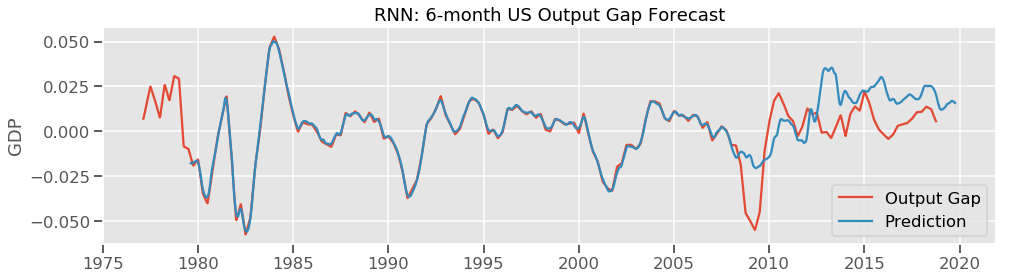

In [244]:
pred = pd.DataFrame(predicted)
pred.set_index(X.index[52:], inplace=True)
pred.columns = ["pred"]
fig = plt.figure(figsize=(16,4))
ax = plt.plot(df_merged.gap[X_scaled.index])
ax = plt.plot(pred.shift(26))
plt.title("RNN: 6-month US Output Gap Forecast")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_rnn")
plt.show()

Epoch 1/20
1469/1469 [==============================] - 20s 14ms/step - loss: 9.3618e-04
Epoch 2/20
1469/1469 [==============================] - 11s 7ms/step - loss: 2.3797e-04
Epoch 3/20
1469/1469 [==============================] - 11s 7ms/step - loss: 1.4244e-04
Epoch 4/20
1469/1469 [==============================] - 11s 7ms/step - loss: 1.0145e-04
Epoch 5/20
1469/1469 [==============================] - 12s 8ms/step - loss: 8.5388e-05
Epoch 6/20
1469/1469 [==============================] - 13s 9ms/step - loss: 6.5238e-05
Epoch 7/20
1469/1469 [==============================] - 12s 8ms/step - loss: 6.1987e-05
Epoch 8/20
1469/1469 [==============================] - 11s 7ms/step - loss: 4.4618e-05
Epoch 9/20
1469/1469 [==============================] - 11s 7ms/step - loss: 4.5025e-05
Epoch 10/20
1469/1469 [==============================] - 11s 7ms/step - loss: 3.5918e-05
Epoch 11/20
1469/1469 [==============================] - 11s 7ms/step - loss: 3.4820e-05
Epoch 12/20
1469/1469 [======

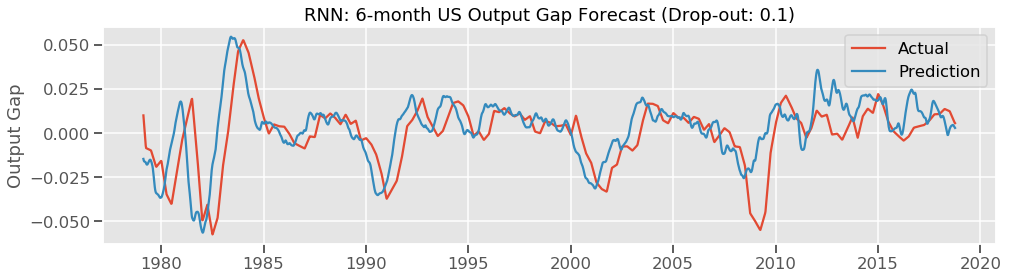

Epoch 1/20
1469/1469 [==============================] - 22s 15ms/step - loss: 0.0014
Epoch 2/20
1469/1469 [==============================] - 11s 7ms/step - loss: 3.6226e-04
Epoch 3/20
1469/1469 [==============================] - 11s 7ms/step - loss: 2.0300e-04
Epoch 4/20
1469/1469 [==============================] - 11s 7ms/step - loss: 1.5016e-04
Epoch 5/20
1469/1469 [==============================] - 11s 7ms/step - loss: 1.1486e-04
Epoch 6/20
1469/1469 [==============================] - 11s 7ms/step - loss: 9.4618e-05
Epoch 7/20
1469/1469 [==============================] - 11s 7ms/step - loss: 8.2941e-05
Epoch 8/20
1469/1469 [==============================] - 11s 7ms/step - loss: 7.2294e-05
Epoch 9/20
1469/1469 [==============================] - 11s 7ms/step - loss: 6.5194e-05
Epoch 10/20
1469/1469 [==============================] - 11s 7ms/step - loss: 5.6357e-05
Epoch 11/20
1469/1469 [==============================] - 11s 7ms/step - loss: 5.0475e-05
Epoch 12/20
1469/1469 [==========

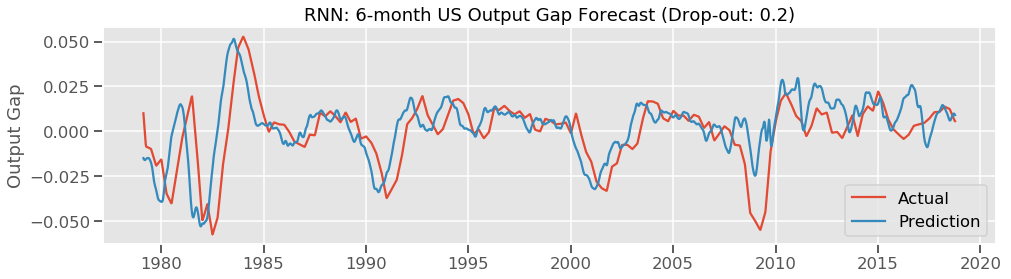

Epoch 1/20
1469/1469 [==============================] - 23s 16ms/step - loss: 0.0019
Epoch 2/20
1469/1469 [==============================] - 11s 7ms/step - loss: 5.6249e-04
Epoch 3/20
1469/1469 [==============================] - 11s 8ms/step - loss: 3.3124e-04
Epoch 4/20
1469/1469 [==============================] - 11s 7ms/step - loss: 2.4907e-04
Epoch 5/20
1469/1469 [==============================] - 11s 7ms/step - loss: 1.8636e-04
Epoch 6/20
1469/1469 [==============================] - 11s 8ms/step - loss: 1.5587e-04
Epoch 7/20
1469/1469 [==============================] - 12s 8ms/step - loss: 1.2334e-04
Epoch 8/20
1469/1469 [==============================] - 14s 9ms/step - loss: 1.0677e-04
Epoch 9/20
1469/1469 [==============================] - 12s 8ms/step - loss: 9.5440e-05
Epoch 10/20
1469/1469 [==============================] - 11s 8ms/step - loss: 8.4476e-05
Epoch 11/20
1469/1469 [==============================] - 11s 8ms/step - loss: 6.8653e-05
Epoch 12/20
1469/1469 [==========

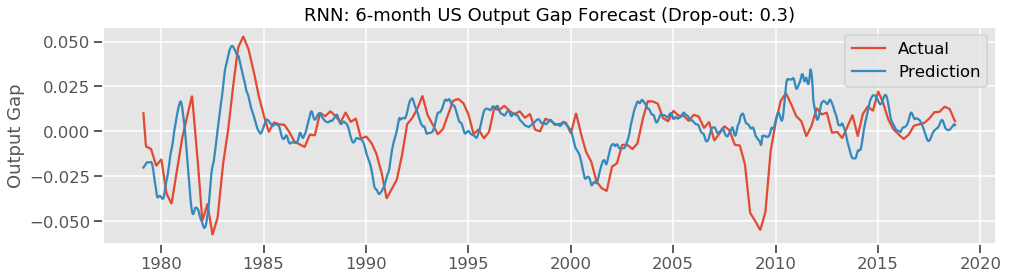

Epoch 1/20
1469/1469 [==============================] - 22s 15ms/step - loss: 0.0039
Epoch 2/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0010
Epoch 3/20
1469/1469 [==============================] - 11s 7ms/step - loss: 6.1467e-04
Epoch 4/20
1469/1469 [==============================] - 12s 8ms/step - loss: 4.6480e-04
Epoch 5/20
1469/1469 [==============================] - 12s 8ms/step - loss: 3.4543e-04
Epoch 6/20
1469/1469 [==============================] - 11s 7ms/step - loss: 2.9512e-04
Epoch 7/20
1469/1469 [==============================] - 11s 7ms/step - loss: 2.5532e-04
Epoch 8/20
1469/1469 [==============================] - 11s 7ms/step - loss: 1.9884e-04
Epoch 9/20
1469/1469 [==============================] - 11s 7ms/step - loss: 1.8694e-04
Epoch 10/20
1469/1469 [==============================] - 11s 7ms/step - loss: 1.5312e-04
Epoch 11/20
1469/1469 [==============================] - 11s 7ms/step - loss: 1.3510e-04
Epoch 12/20
1469/1469 [==============

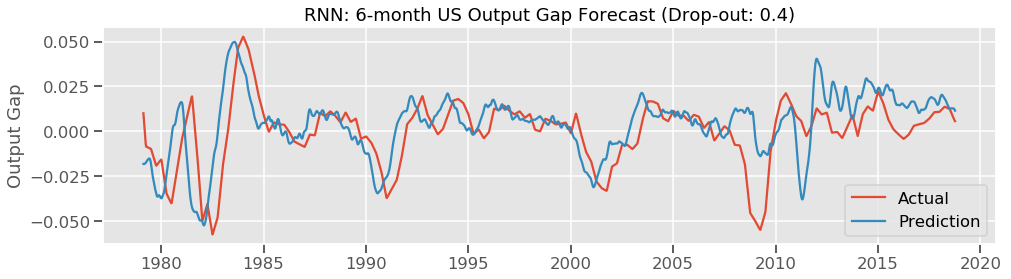

Epoch 1/20
1469/1469 [==============================] - 26s 18ms/step - loss: 0.0045
Epoch 2/20
1469/1469 [==============================] - 11s 8ms/step - loss: 0.0014
Epoch 3/20
1469/1469 [==============================] - 13s 9ms/step - loss: 8.5341e-04
Epoch 4/20
1469/1469 [==============================] - 13s 9ms/step - loss: 6.2979e-04
Epoch 5/20
1469/1469 [==============================] - 13s 9ms/step - loss: 5.1271e-04
Epoch 6/20
1469/1469 [==============================] - 12s 8ms/step - loss: 3.8141e-04
Epoch 7/20
1469/1469 [==============================] - 12s 8ms/step - loss: 3.4060e-04
Epoch 8/20
1469/1469 [==============================] - 11s 8ms/step - loss: 2.5794e-04
Epoch 9/20
1469/1469 [==============================] - 12s 8ms/step - loss: 2.3597e-04
Epoch 10/20
1469/1469 [==============================] - 11s 7ms/step - loss: 2.0758e-04
Epoch 11/20
1469/1469 [==============================] - 11s 7ms/step - loss: 2.0031e-04
Epoch 12/20
1469/1469 [==============

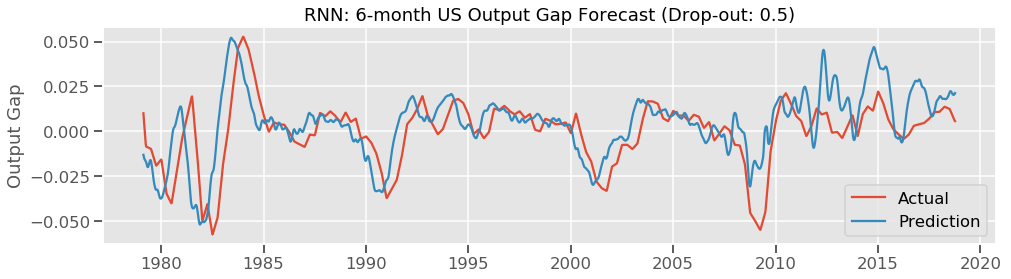

W1007 15:30:26.259308 140736144978816 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1007 15:30:26.495879 140736144978816 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1007 15:30:26.761434 140736144978816 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1007 15:30:27.007412 140736144978816 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/20
1469/1469 [==============================] - 24s 16ms/step - loss: 0.0051
Epoch 2/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0018
Epoch 3/20
1469/1469 [==============================] - 11s 8ms/step - loss: 0.0010
Epoch 4/20
1469/1469 [==============================] - 11s 8ms/step - loss: 7.3467e-04
Epoch 5/20
1469/1469 [==============================] - 11s 7ms/step - loss: 5.5293e-04
Epoch 6/20
1469/1469 [==============================] - 11s 8ms/step - loss: 4.5924e-04
Epoch 7/20
1469/1469 [==============================] - 11s 8ms/step - loss: 3.6693e-04
Epoch 8/20
1469/1469 [==============================] - 11s 7ms/step - loss: 3.0567e-04
Epoch 9/20
1469/1469 [==============================] - 11s 8ms/step - loss: 2.6763e-04
Epoch 10/20
1469/1469 [==============================] - 11s 8ms/step - loss: 2.3780e-04
Epoch 11/20
1469/1469 [==============================] - 11s 8ms/step - loss: 2.1368e-04
Epoch 12/20
1469/1469 [==================

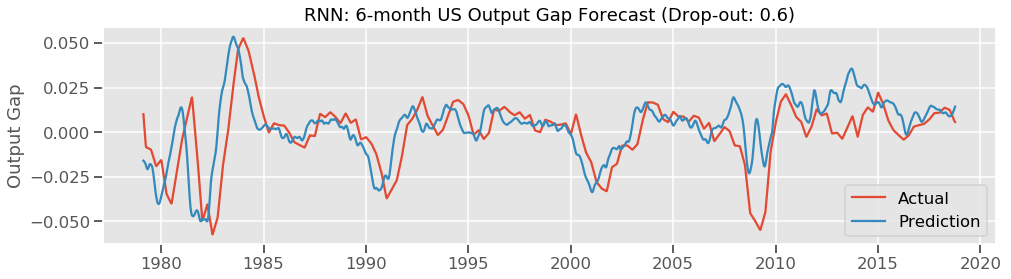

W1007 15:34:37.833992 140736144978816 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/20
1469/1469 [==============================] - 24s 16ms/step - loss: 0.0126
Epoch 2/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0047
Epoch 3/20
1469/1469 [==============================] - 11s 8ms/step - loss: 0.0027
Epoch 4/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0019
Epoch 5/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0016
Epoch 6/20
1469/1469 [==============================] - 12s 8ms/step - loss: 0.0012
Epoch 7/20
1469/1469 [==============================] - 11s 7ms/step - loss: 9.4074e-04
Epoch 8/20
1469/1469 [==============================] - 11s 7ms/step - loss: 8.4619e-04
Epoch 9/20
1469/1469 [==============================] - 11s 8ms/step - loss: 6.8221e-04
Epoch 10/20
1469/1469 [==============================] - 11s 8ms/step - loss: 5.8340e-04
Epoch 11/20
1469/1469 [==============================] - 13s 9ms/step - loss: 5.1827e-04
Epoch 12/20
1469/1469 [==============================

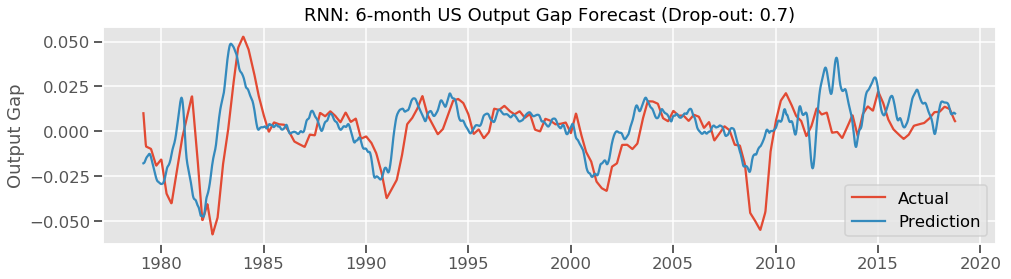

Epoch 1/20
1469/1469 [==============================] - 33s 22ms/step - loss: 0.0307
Epoch 2/20
1469/1469 [==============================] - 12s 8ms/step - loss: 0.0151
Epoch 3/20
1469/1469 [==============================] - 12s 8ms/step - loss: 0.0084
Epoch 4/20
1469/1469 [==============================] - 12s 8ms/step - loss: 0.0056
Epoch 5/20
1469/1469 [==============================] - 12s 8ms/step - loss: 0.0041
Epoch 6/20
1469/1469 [==============================] - 11s 8ms/step - loss: 0.0033
Epoch 7/20
1469/1469 [==============================] - 12s 8ms/step - loss: 0.0026
Epoch 8/20
1469/1469 [==============================] - 11s 8ms/step - loss: 0.0021
Epoch 9/20
1469/1469 [==============================] - 12s 8ms/step - loss: 0.0019
Epoch 10/20
1469/1469 [==============================] - 12s 8ms/step - loss: 0.0016
Epoch 11/20
1469/1469 [==============================] - 12s 8ms/step - loss: 0.0014
Epoch 12/20
1469/1469 [==============================] - 12s 8ms/step - l

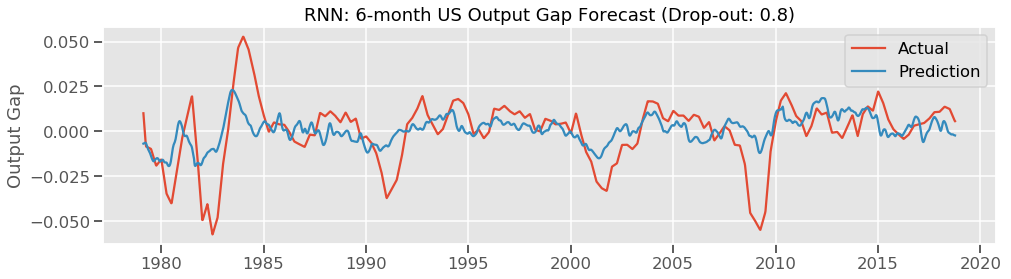

Epoch 1/20
1469/1469 [==============================] - 25s 17ms/step - loss: 0.1843
Epoch 2/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.1292
Epoch 3/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0727
Epoch 4/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0464
Epoch 5/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0386
Epoch 6/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0260
Epoch 7/20
1469/1469 [==============================] - 11s 8ms/step - loss: 0.0217
Epoch 8/20
1469/1469 [==============================] - 12s 8ms/step - loss: 0.0166
Epoch 9/20
1469/1469 [==============================] - 12s 8ms/step - loss: 0.0147
Epoch 10/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0119
Epoch 11/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0088
Epoch 12/20
1469/1469 [==============================] - 13s 9ms/step - l

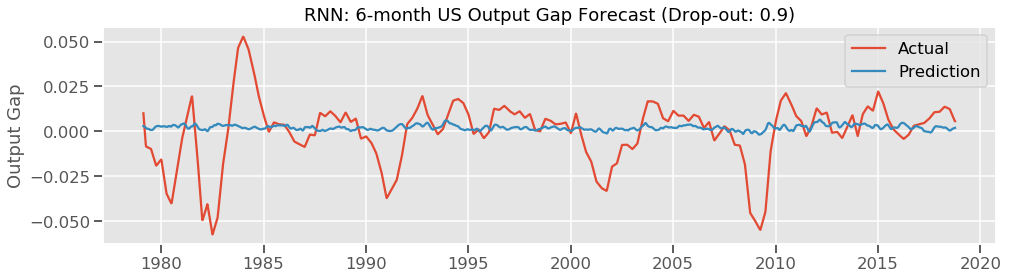

In [192]:
for i in range(1, 10):
    drop_out = i / 10

    regressor = Sequential()

    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_rnn.shape[1], X_train_rnn.shape[2])))
    regressor.add(Dropout(drop_out))

    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(drop_out))

    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(drop_out))

    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(drop_out))

    regressor.add(Dense(units = 1))

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    regressor.fit(X_train_rnn, 
              y_train_rnn, 
              epochs=20, 
              batch_size=32)
    
    predicted = regressor.predict(X_all_rnn)
    pred = pd.DataFrame(predicted)
    pred.set_index(X.index[52:], inplace=True)
    pred.columns = ["pred"]
    fig = plt.figure(figsize=(16,4))
    ax = plt.plot(pd.merge(df_merged.gap[X_scaled.index], pred, on="date"))
    plt.title("RNN: 6-month US Output Gap Forecast (Drop-out: {})".format(drop_out))
    plt.ylabel("Output Gap")
    plt.legend(["Actual", "Prediction"])
    plt.savefig("../images/6m_gap_rnn_{}.png".format(drop_out))
    plt.show()

In [193]:
prediction_dict = {}
for i in range(1, 9):
    drop_out = i / 10

    prediction_list = []
    for i in range (0,10):
        regressor = Sequential()

        regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train_rnn.shape[1], X_train_rnn.shape[2])))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units = 50, return_sequences = True))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units = 50, return_sequences = True))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units = 50))
        regressor.add(Dropout(drop_out))

        regressor.add(Dense(units = 1))

        regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

        regressor.fit(X_train_rnn, 
                  y_train_rnn, 
                  epochs=75, 
                  batch_size=32)

        predicted = regressor.predict(X_all_rnn)
        pred = pd.DataFrame(predicted)
        pred.set_index(X.index[52:], inplace=True)
        pred.columns = [i]
        prediction_list.append(pred)
    prediction_dict[drop_out] = prediction_list

Epoch 1/20
1469/1469 [==============================] - 26s 18ms/step - loss: 8.1800e-04
Epoch 2/20
1469/1469 [==============================] - 11s 7ms/step - loss: 1.9130e-04
Epoch 3/20
1469/1469 [==============================] - 12s 8ms/step - loss: 1.2486e-04
Epoch 4/20
1469/1469 [==============================] - 11s 7ms/step - loss: 8.5346e-05
Epoch 5/20
1469/1469 [==============================] - 11s 8ms/step - loss: 6.3737e-05
Epoch 6/20
1469/1469 [==============================] - 12s 8ms/step - loss: 4.5855e-05
Epoch 7/20
1469/1469 [==============================] - 11s 8ms/step - loss: 4.4832e-05
Epoch 8/20
1469/1469 [==============================] - 11s 8ms/step - loss: 4.1820e-05
Epoch 9/20
1469/1469 [==============================] - 11s 8ms/step - loss: 3.4581e-05
Epoch 10/20
1469/1469 [==============================] - 11s 7ms/step - loss: 3.1240e-05
Epoch 11/20
1469/1469 [==============================] - 11s 8ms/step - loss: 2.8244e-05
Epoch 12/20
1469/1469 [======

1469/1469 [==============================] - 11s 8ms/step - loss: 8.8497e-05
Epoch 6/20
1469/1469 [==============================] - 12s 8ms/step - loss: 7.2392e-05
Epoch 7/20
1469/1469 [==============================] - 11s 7ms/step - loss: 5.8777e-05
Epoch 8/20
1469/1469 [==============================] - 11s 8ms/step - loss: 5.3606e-05
Epoch 9/20
1469/1469 [==============================] - 11s 8ms/step - loss: 4.3217e-05
Epoch 10/20
1469/1469 [==============================] - 11s 8ms/step - loss: 3.3866e-05
Epoch 11/20
1469/1469 [==============================] - 11s 8ms/step - loss: 3.6257e-05
Epoch 12/20
1469/1469 [==============================] - 11s 7ms/step - loss: 3.1838e-05
Epoch 13/20
1469/1469 [==============================] - 11s 8ms/step - loss: 2.7387e-05
Epoch 14/20
1469/1469 [==============================] - 11s 8ms/step - loss: 2.6854e-05
Epoch 15/20
1469/1469 [==============================] - 11s 8ms/step - loss: 2.5161e-05
Epoch 16/20
1469/1469 [==============

1469/1469 [==============================] - 11s 8ms/step - loss: 5.3275e-05
Epoch 10/20
1469/1469 [==============================] - 12s 8ms/step - loss: 4.6045e-05
Epoch 11/20
1469/1469 [==============================] - 11s 8ms/step - loss: 4.2129e-05
Epoch 12/20
1469/1469 [==============================] - 11s 8ms/step - loss: 4.1487e-05
Epoch 13/20
1469/1469 [==============================] - 11s 8ms/step - loss: 3.7175e-05
Epoch 14/20
1469/1469 [==============================] - 11s 8ms/step - loss: 3.3818e-05
Epoch 15/20
1469/1469 [==============================] - 11s 7ms/step - loss: 3.2592e-05
Epoch 16/20
1469/1469 [==============================] - 11s 8ms/step - loss: 3.0701e-05
Epoch 17/20
1469/1469 [==============================] - 11s 8ms/step - loss: 2.7246e-05
Epoch 18/20
1469/1469 [==============================] - 11s 8ms/step - loss: 2.4305e-05
Epoch 19/20
1469/1469 [==============================] - 11s 8ms/step - loss: 2.7541e-05
Epoch 20/20
1469/1469 [==========

1469/1469 [==============================] - 10s 7ms/step - loss: 6.4837e-05
Epoch 14/20
1469/1469 [==============================] - 10s 7ms/step - loss: 6.0086e-05
Epoch 15/20
1469/1469 [==============================] - 10s 7ms/step - loss: 5.2719e-05
Epoch 16/20
1469/1469 [==============================] - 10s 7ms/step - loss: 4.9222e-05
Epoch 17/20
1469/1469 [==============================] - 10s 7ms/step - loss: 4.5931e-05
Epoch 18/20
1469/1469 [==============================] - 10s 7ms/step - loss: 4.4199e-05
Epoch 19/20
1469/1469 [==============================] - 10s 7ms/step - loss: 4.1059e-05
Epoch 20/20
1469/1469 [==============================] - 10s 7ms/step - loss: 3.8904e-05
Epoch 1/20
1469/1469 [==============================] - 38s 26ms/step - loss: 0.0021
Epoch 2/20
1469/1469 [==============================] - 10s 7ms/step - loss: 5.6570e-04
Epoch 3/20
1469/1469 [==============================] - 10s 7ms/step - loss: 3.3220e-04
Epoch 4/20
1469/1469 [=================

1469/1469 [==============================] - 10s 7ms/step - loss: 6.5518e-05
Epoch 18/20
1469/1469 [==============================] - 11s 7ms/step - loss: 6.0197e-05
Epoch 19/20
1469/1469 [==============================] - 10s 7ms/step - loss: 5.3034e-05
Epoch 20/20
1469/1469 [==============================] - 10s 7ms/step - loss: 5.4582e-05
Epoch 1/20
1469/1469 [==============================] - 43s 29ms/step - loss: 0.0031
Epoch 2/20
1469/1469 [==============================] - 10s 7ms/step - loss: 9.6802e-04
Epoch 3/20
1469/1469 [==============================] - 10s 7ms/step - loss: 5.1744e-04
Epoch 4/20
1469/1469 [==============================] - 10s 7ms/step - loss: 3.8380e-04
Epoch 5/20
1469/1469 [==============================] - 11s 7ms/step - loss: 2.8984e-04
Epoch 6/20
1469/1469 [==============================] - 10s 7ms/step - loss: 2.4646e-04
Epoch 7/20
1469/1469 [==============================] - 10s 7ms/step - loss: 2.0077e-04
Epoch 8/20
1469/1469 [=====================

1469/1469 [==============================] - 48s 33ms/step - loss: 0.0053
Epoch 2/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0017
Epoch 3/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0010
Epoch 4/20
1469/1469 [==============================] - 10s 7ms/step - loss: 7.5772e-04
Epoch 5/20
1469/1469 [==============================] - 11s 7ms/step - loss: 5.8442e-04
Epoch 6/20
1469/1469 [==============================] - 10s 7ms/step - loss: 4.4499e-04
Epoch 7/20
1469/1469 [==============================] - 12s 8ms/step - loss: 4.0052e-04
Epoch 8/20
1469/1469 [==============================] - 10s 7ms/step - loss: 3.3451e-04
Epoch 9/20
1469/1469 [==============================] - 10s 7ms/step - loss: 2.6448e-04
Epoch 10/20
1469/1469 [==============================] - 10s 7ms/step - loss: 2.4541e-04
Epoch 11/20
1469/1469 [==============================] - 10s 7ms/step - loss: 2.1861e-04
Epoch 12/20
1469/1469 [=============================

1469/1469 [==============================] - 11s 7ms/step - loss: 2.3815e-04
Epoch 15/20
1469/1469 [==============================] - 10s 7ms/step - loss: 2.0936e-04
Epoch 16/20
1469/1469 [==============================] - 10s 7ms/step - loss: 1.8796e-04
Epoch 17/20
1469/1469 [==============================] - 10s 7ms/step - loss: 1.7856e-04
Epoch 18/20
1469/1469 [==============================] - 10s 7ms/step - loss: 1.6634e-04
Epoch 19/20
1469/1469 [==============================] - 10s 7ms/step - loss: 1.5722e-04
Epoch 20/20
1469/1469 [==============================] - 11s 7ms/step - loss: 1.4133e-04
Epoch 1/20
1469/1469 [==============================] - 50s 34ms/step - loss: 0.0064
Epoch 2/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0023
Epoch 3/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0013
Epoch 4/20
1469/1469 [==============================] - 10s 7ms/step - loss: 9.1192e-04
Epoch 5/20
1469/1469 [==========================

1469/1469 [==============================] - 11s 7ms/step - loss: 1.4193e-04
Epoch 1/20
1469/1469 [==============================] - 55s 37ms/step - loss: 0.0130
Epoch 2/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0044
Epoch 3/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0026
Epoch 4/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0019
Epoch 5/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0014
Epoch 6/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0011
Epoch 7/20
1469/1469 [==============================] - 10s 7ms/step - loss: 9.2061e-04
Epoch 8/20
1469/1469 [==============================] - 10s 7ms/step - loss: 7.6514e-04
Epoch 9/20
1469/1469 [==============================] - 10s 7ms/step - loss: 6.4877e-04
Epoch 10/20
1469/1469 [==============================] - 10s 7ms/step - loss: 5.4809e-04
Epoch 11/20
1469/1469 [==============================] - 11s 7ms/

Epoch 14/20
1469/1469 [==============================] - 10s 7ms/step - loss: 3.6218e-04
Epoch 15/20
1469/1469 [==============================] - 11s 7ms/step - loss: 3.3686e-04
Epoch 16/20
1469/1469 [==============================] - 10s 7ms/step - loss: 2.9691e-04
Epoch 17/20
1469/1469 [==============================] - 11s 7ms/step - loss: 2.8231e-04
Epoch 18/20
1469/1469 [==============================] - 10s 7ms/step - loss: 2.4964e-04
Epoch 19/20
1469/1469 [==============================] - 10s 7ms/step - loss: 2.3663e-04
Epoch 20/20
1469/1469 [==============================] - 10s 7ms/step - loss: 2.0870e-04
Epoch 1/20
1469/1469 [==============================] - 58s 40ms/step - loss: 0.0140
Epoch 2/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0054
Epoch 3/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0032
Epoch 4/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0023
Epoch 5/20
1469/1469 [==================

1469/1469 [==============================] - 70s 48ms/step - loss: 0.0402
Epoch 2/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0174
Epoch 3/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0117
Epoch 4/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0068
Epoch 5/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0052
Epoch 6/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0039
Epoch 7/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0034
Epoch 8/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0027
Epoch 9/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0021
Epoch 10/20
1469/1469 [==============================] - 11s 7ms/step - loss: 0.0020
Epoch 11/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0017
Epoch 12/20
1469/1469 [==============================] - 10s 7ms/step - loss: 0.0014

In [197]:
prediction_dict[0.1]

[                   0
 date                
 1979-02-18 -0.018071
 1979-02-25 -0.019224
 1979-03-04 -0.020197
 1979-03-11 -0.020954
 1979-03-18 -0.021541
 1979-03-25 -0.021973
 1979-04-01 -0.022226
 1979-04-08 -0.022285
 1979-04-15 -0.022184
 1979-04-22 -0.022005
 1979-04-29 -0.021780
 1979-05-06 -0.021415
 1979-05-13 -0.020805
 1979-05-20 -0.020004
 1979-05-27 -0.019247
 1979-06-03 -0.018715
 1979-06-10 -0.018518
 1979-06-17 -0.018738
 1979-06-24 -0.019351
 1979-07-01 -0.020256
 1979-07-08 -0.021363
 1979-07-15 -0.022517
 1979-07-22 -0.023634
 1979-07-29 -0.024646
 1979-08-05 -0.025622
 1979-08-12 -0.026568
 1979-08-19 -0.027583
 1979-08-26 -0.028762
 1979-09-02 -0.030121
 1979-09-09 -0.031650
 ...              ...
 2019-03-17 -0.004323
 2019-03-24 -0.003656
 2019-03-31 -0.002935
 2019-04-07 -0.002265
 2019-04-14 -0.001613
 2019-04-21 -0.000988
 2019-04-28 -0.000404
 2019-05-05  0.000086
 2019-05-12  0.000470
 2019-05-19  0.000650
 2019-05-26  0.000550
 2019-06-02  0.000239
 2019-06-0

In [198]:
pred_df_dict = {}
for key in prediction_dict.keys():
    pred_df_dict[key] = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), prediction_dict[key])

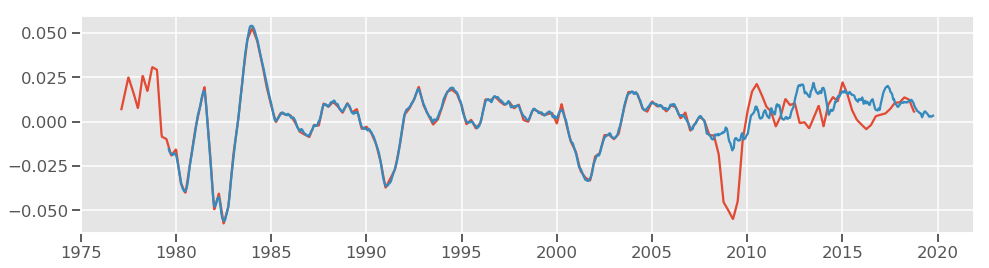

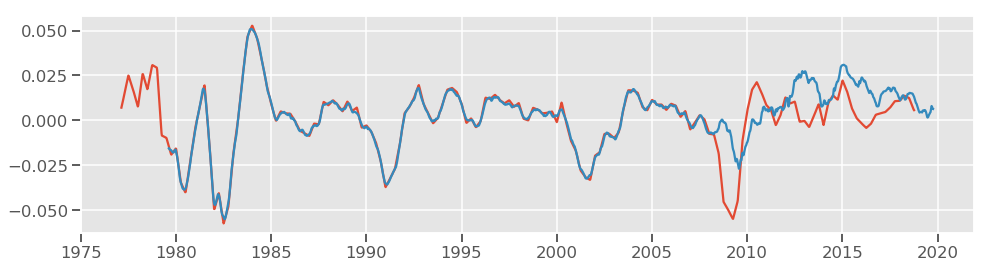

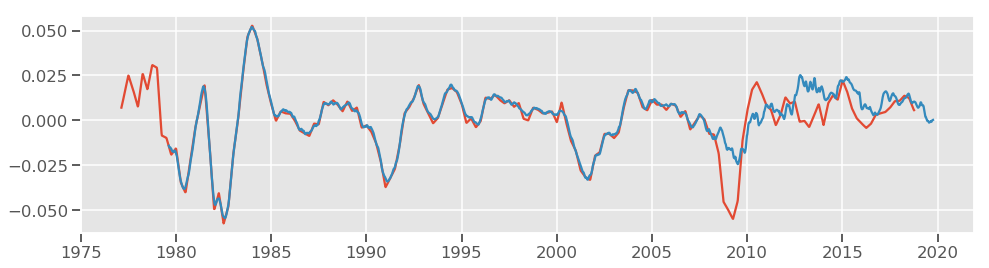

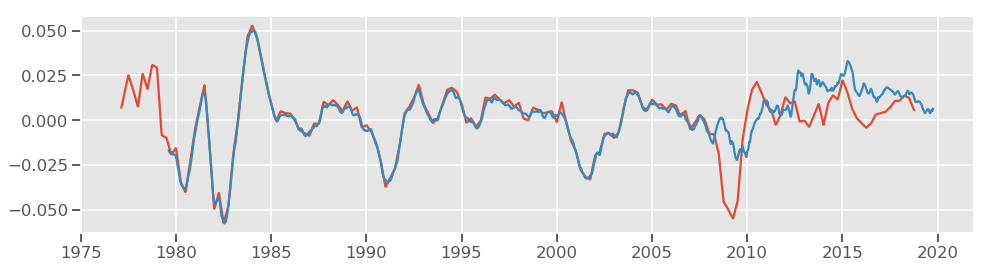

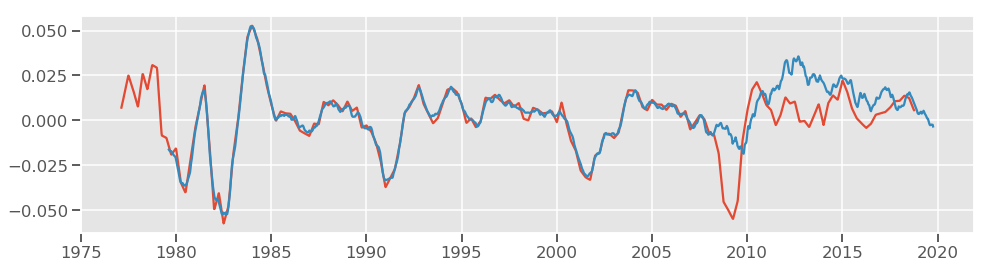

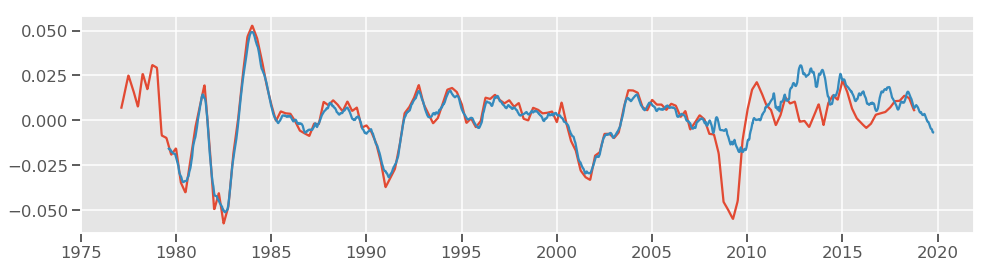

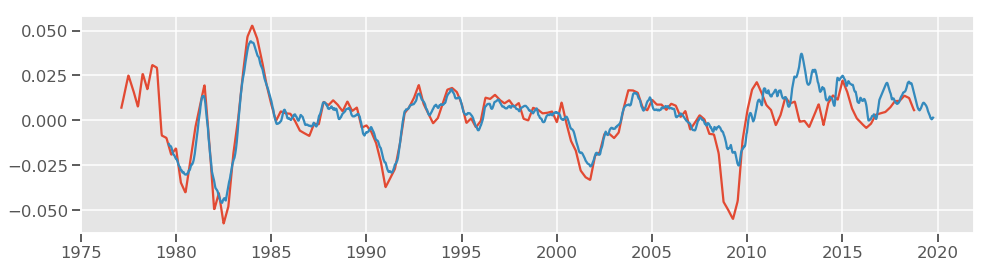

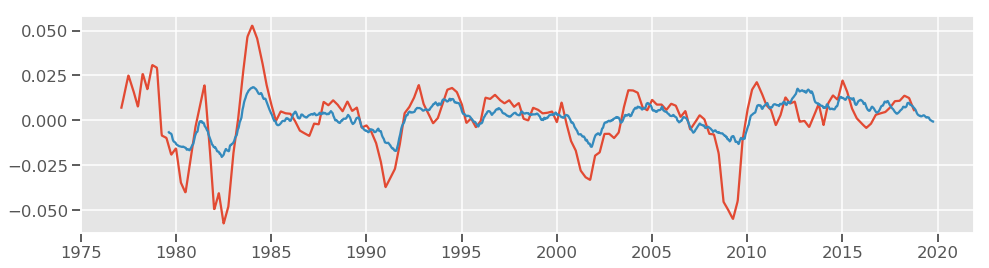

In [219]:
for key in pred_df_dict.keys():
    fig = plt.figure(figsize=(16,4))
    pred_median = pd.DataFrame(pred_df_dict[key].median(axis=1).shift(26))
    ax = plt.plot(df_merged.gap[X_scaled.index])
    ax = plt.plot(pred_median)

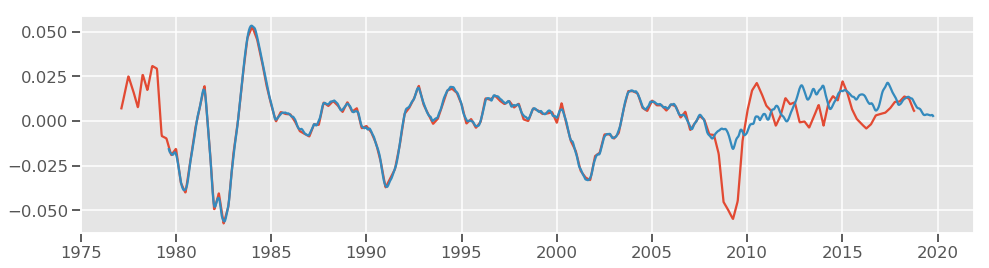

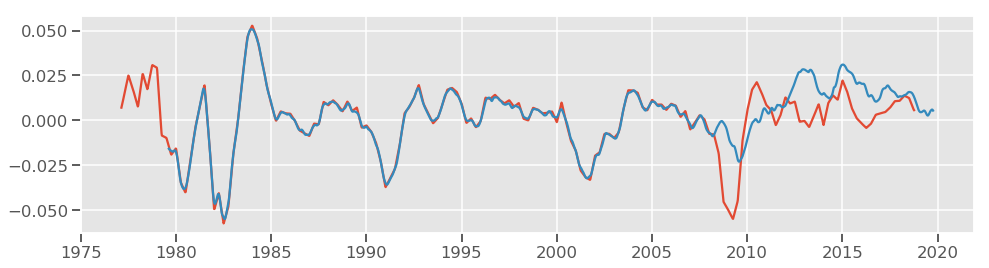

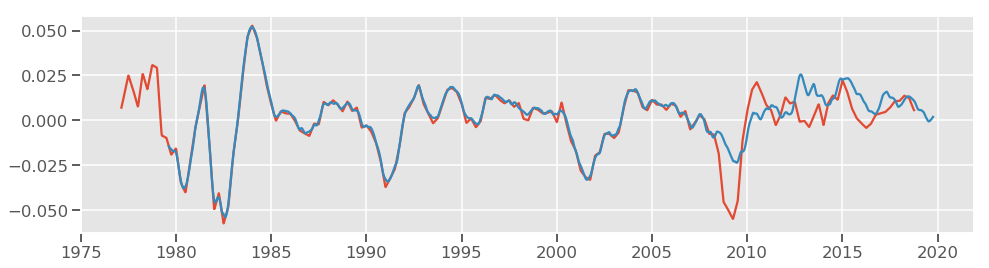

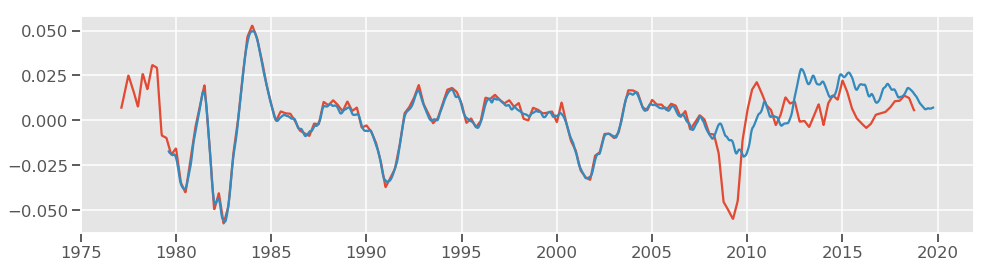

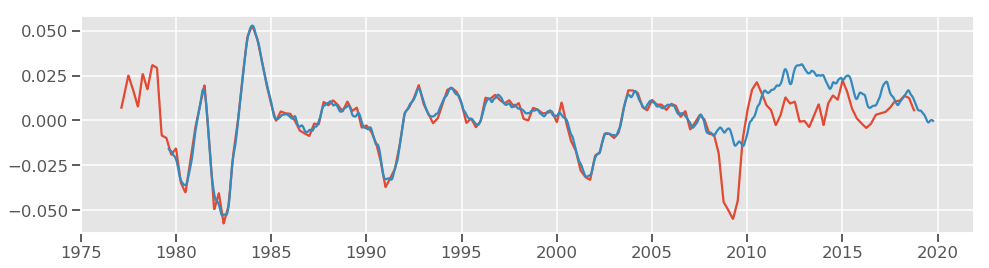

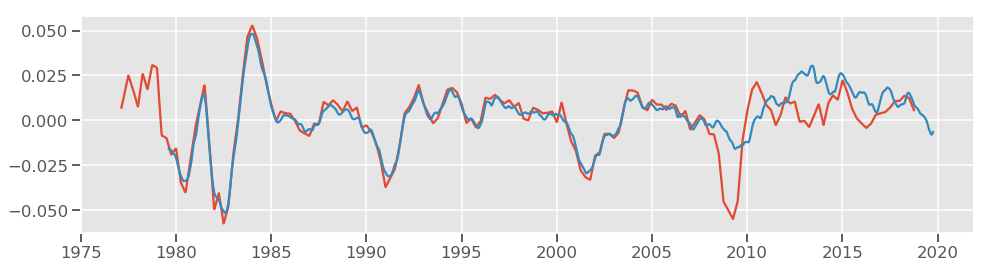

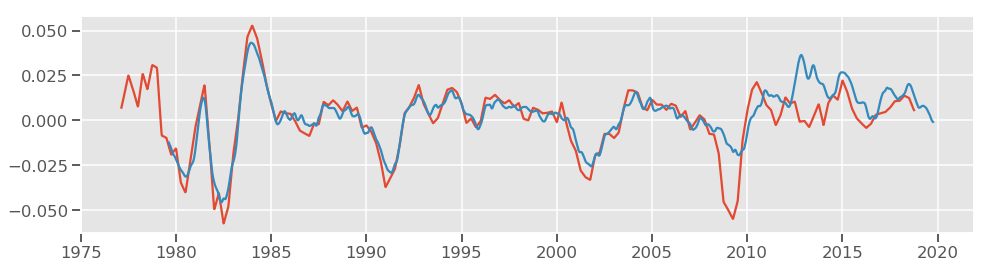

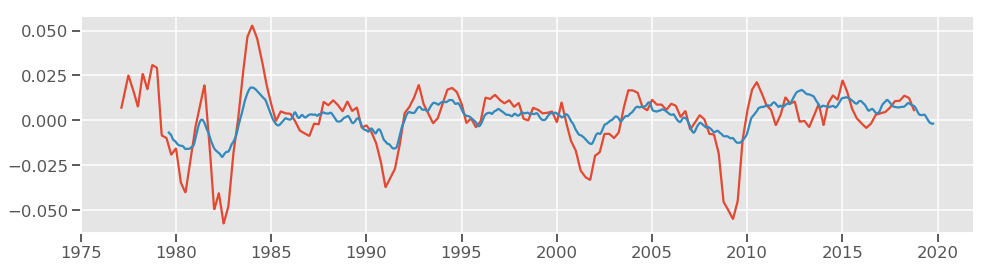

In [218]:
for key in pred_df_dict.keys():
    fig = plt.figure(figsize=(16,4))
    pred_avg = pd.DataFrame(pred_df_dict[key].mean(axis=1).shift(26))
    ax = plt.plot(df_merged.gap[X_scaled.index])
    ax = plt.plot(pred_avg)

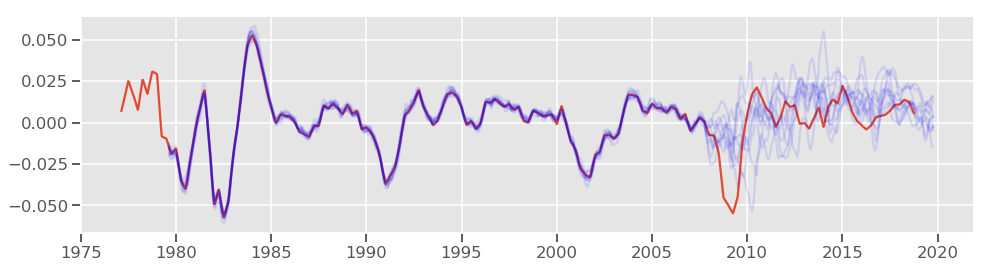

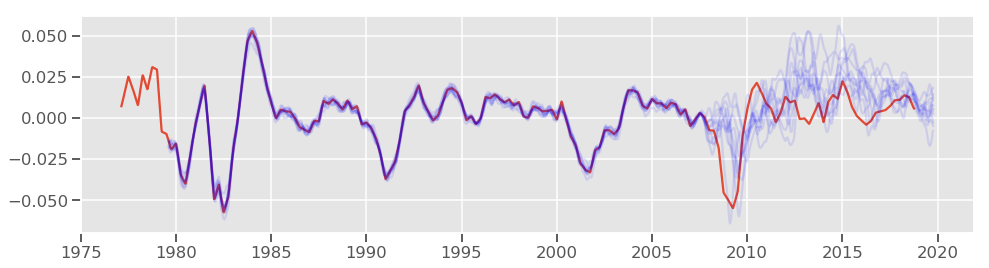

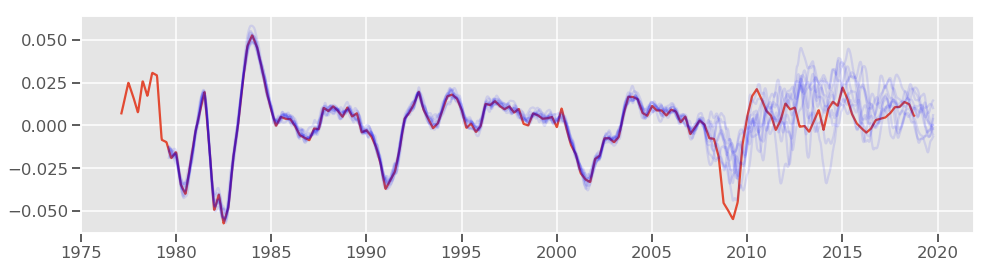

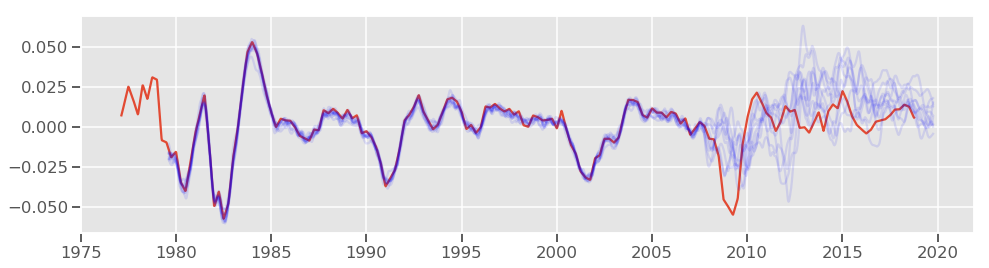

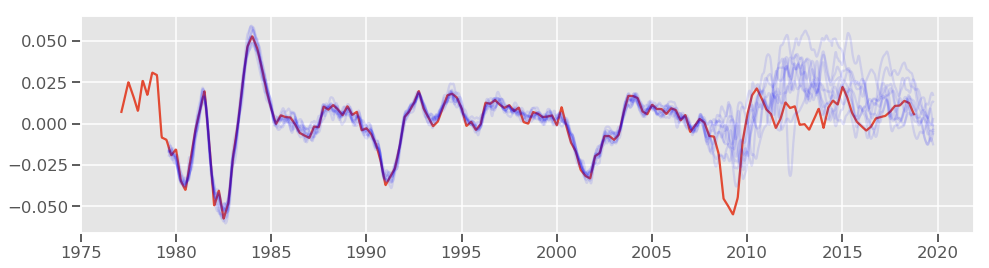

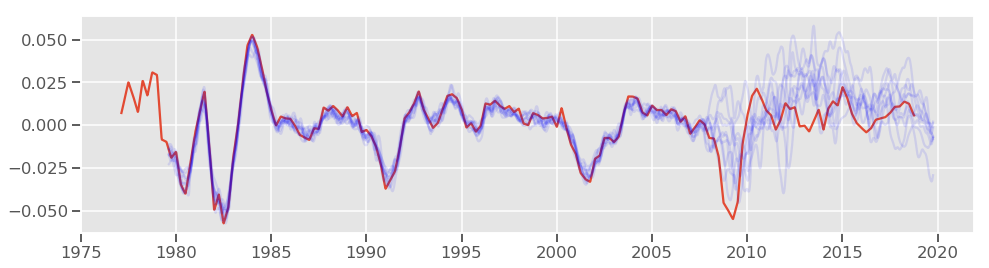

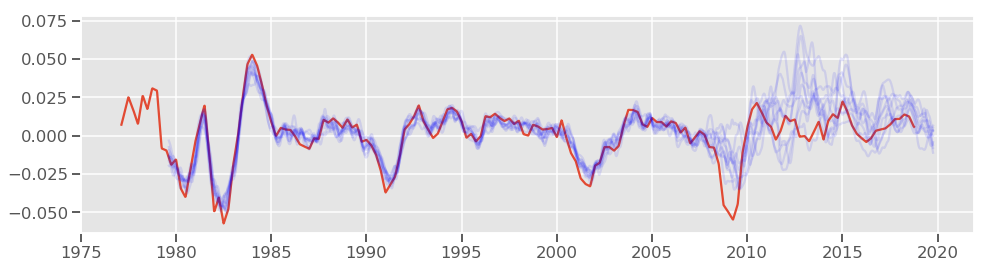

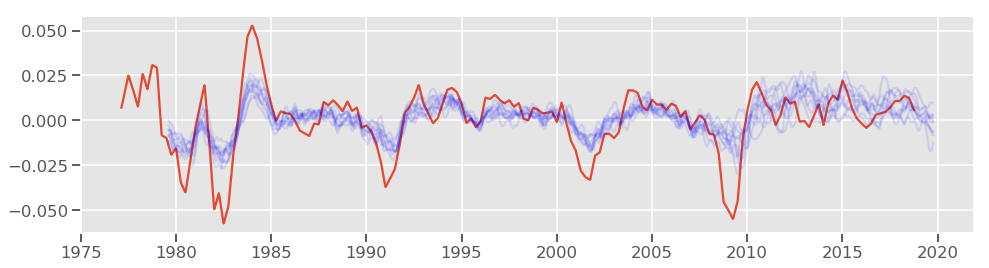

In [217]:
for key in pred_df_dict.keys():
    fig = plt.figure(figsize=(16,4))
    pred_each = pd.DataFrame(pred_df_dict[key].shift(26))
    ax = plt.plot(df_merged.gap[X_scaled.index])
    ax = plt.plot(pred_each, c="blue", alpha = 0.1)

In [98]:
prediction_list = []
for i in range (0,10):
    regressor = Sequential()

    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    regressor.add(Dropout(0.5))

    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))

    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))
    
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))

    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))
    
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.5))
    
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.5))

    regressor.add(Dense(units=1))

    regressor.compile(optimizer='adam', loss='mean_squared_error')

    regressor.fit(X_train_g_rnn, 
                  y_train_g_rnn, 
                  epochs=50, 
                  batch_size=50)

    predicted = regressor.predict(X_all_g_rnn)
    pred = pd.DataFrame(predicted)
    pred.set_index(X.index[52:], inplace=True)
    pred.columns = [i]
    prediction_list.append(pred)
    print("--- {}% completed ---".format(i*10+10))

pred_gap_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), prediction_list)

Epoch 1/50
1469/1469 [==============================] - 200s 136ms/step - loss: 3.1264e-04
Epoch 2/50
1469/1469 [==============================] - 12s 8ms/step - loss: 1.0353e-04
Epoch 3/50
1469/1469 [==============================] - 12s 8ms/step - loss: 7.7194e-05
Epoch 4/50
1469/1469 [==============================] - 12s 8ms/step - loss: 5.7161e-05
Epoch 5/50
1469/1469 [==============================] - 12s 8ms/step - loss: 5.3525e-05
Epoch 6/50
1469/1469 [==============================] - 12s 8ms/step - loss: 4.8864e-05
Epoch 7/50
1469/1469 [==============================] - 12s 8ms/step - loss: 4.5230e-05
Epoch 8/50
1469/1469 [==============================] - 12s 8ms/step - loss: 4.7912e-05
Epoch 9/50
1469/1469 [==============================] - 12s 8ms/step - loss: 3.5894e-05
Epoch 10/50
1469/1469 [==============================] - 12s 8ms/step - loss: 3.3444e-05
Epoch 11/50
1469/1469 [==============================] - 12s 8ms/step - loss: 3.2026e-05
Epoch 12/50
1469/1469 [====

1469/1469 [==============================] - 12s 8ms/step - loss: 1.9552e-05
Epoch 43/50
1469/1469 [==============================] - 12s 8ms/step - loss: 1.6852e-05
Epoch 44/50
1469/1469 [==============================] - 11s 8ms/step - loss: 1.9378e-05
Epoch 45/50
1469/1469 [==============================] - 12s 8ms/step - loss: 1.9228e-05
Epoch 46/50
1469/1469 [==============================] - 11s 8ms/step - loss: 2.6218e-05
Epoch 47/50
1469/1469 [==============================] - 11s 8ms/step - loss: 2.4680e-05
Epoch 48/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.0280e-05
Epoch 49/50
1469/1469 [==============================] - 12s 8ms/step - loss: 1.8935e-05
Epoch 50/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.0545e-05
--- 20% completed ---
Epoch 1/50
1469/1469 [==============================] - 155s 105ms/step - loss: 3.0114e-04
Epoch 2/50
1469/1469 [==============================] - 15s 10ms/step - loss: 1.1613e-04
Epoch 3/5

1469/1469 [==============================] - 12s 8ms/step - loss: 1.8268e-05
Epoch 34/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.1653e-05
Epoch 35/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.6434e-05
Epoch 36/50
1469/1469 [==============================] - 11s 8ms/step - loss: 2.5265e-05
Epoch 37/50
1469/1469 [==============================] - 11s 8ms/step - loss: 2.1616e-05
Epoch 38/50
1469/1469 [==============================] - 12s 8ms/step - loss: 1.9739e-05
Epoch 39/50
1469/1469 [==============================] - 11s 8ms/step - loss: 1.7632e-05
Epoch 40/50
1469/1469 [==============================] - 12s 8ms/step - loss: 1.9911e-05
Epoch 41/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.0243e-05
Epoch 42/50
1469/1469 [==============================] - 12s 8ms/step - loss: 1.9464e-05
Epoch 43/50
1469/1469 [==============================] - 12s 8ms/step - loss: 1.8812e-05
Epoch 44/50
1469/1469 [==========

1469/1469 [==============================] - 12s 8ms/step - loss: 2.5072e-05
Epoch 25/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.2317e-05
Epoch 26/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.0041e-05
Epoch 27/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.3009e-05
Epoch 28/50
1469/1469 [==============================] - 12s 8ms/step - loss: 1.9970e-05
Epoch 29/50
1469/1469 [==============================] - 12s 8ms/step - loss: 1.9656e-05
Epoch 30/50
1469/1469 [==============================] - 12s 8ms/step - loss: 1.9327e-05
Epoch 31/50
1469/1469 [==============================] - 12s 8ms/step - loss: 1.8467e-05
Epoch 32/50
1469/1469 [==============================] - 11s 8ms/step - loss: 1.8180e-05
Epoch 33/50
1469/1469 [==============================] - 11s 8ms/step - loss: 2.8193e-05
Epoch 34/50
1469/1469 [==============================] - 13s 9ms/step - loss: 3.0491e-05
Epoch 35/50
1469/1469 [==========

1469/1469 [==============================] - 12s 8ms/step - loss: 3.1838e-05
Epoch 16/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.9059e-05
Epoch 17/50
1469/1469 [==============================] - 12s 8ms/step - loss: 3.9510e-05
Epoch 18/50
1469/1469 [==============================] - 12s 8ms/step - loss: 3.2004e-05
Epoch 19/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.9994e-05
Epoch 20/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.5523e-05
Epoch 21/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.4327e-05
Epoch 22/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.2560e-05
Epoch 23/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.3679e-05
Epoch 24/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.8706e-05
Epoch 25/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.5206e-05
Epoch 26/50
1469/1469 [==========

1469/1469 [==============================] - 12s 8ms/step - loss: 5.0547e-05
Epoch 7/50
1469/1469 [==============================] - 12s 8ms/step - loss: 4.7581e-05
Epoch 8/50
1469/1469 [==============================] - 12s 8ms/step - loss: 3.8936e-05
Epoch 9/50
1469/1469 [==============================] - 12s 8ms/step - loss: 4.0911e-05
Epoch 10/50
1469/1469 [==============================] - 12s 8ms/step - loss: 3.4891e-05
Epoch 11/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.9787e-05
Epoch 12/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.8855e-05
Epoch 13/50
1469/1469 [==============================] - 12s 8ms/step - loss: 3.2098e-05
Epoch 14/50
1469/1469 [==============================] - 12s 8ms/step - loss: 3.1090e-05
Epoch 15/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.5120e-05
Epoch 16/50
1469/1469 [==============================] - 12s 8ms/step - loss: 2.6831e-05
Epoch 17/50
1469/1469 [=============

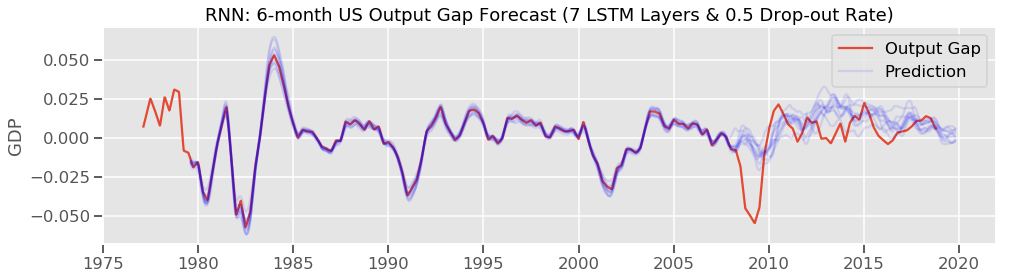

In [99]:
fig = plt.figure(figsize=(16,4))
pred_each = pd.DataFrame(pred_gap_df.shift(26))
ax = plt.plot(df_merged.gap[X_scaled.index])
ax = plt.plot(pred_each, c="blue", alpha = 0.1)
plt.title("RNN: 6-month US Output Gap Forecast (7 LSTM Layers & 0.5 Drop-out Rate)")
plt.ylabel("GDP")
plt.legend(["Output Gap", "Prediction"])
plt.savefig("../images/6m_gap_rnn_7_LSTM_0.5_dropout.png")
plt.show()

In [ ]:
# prediction_dict_gap = {}
for i in range(4, 9):
    drop_out = i / 10

    prediction_list = []
    for i in range (0,10):
        regressor = Sequential()

        regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units=50, return_sequences=True))
        regressor.add(Dropout(drop_out))

        regressor.add(LSTM(units=50))
        regressor.add(Dropout(drop_out))

        regressor.add(Dense(units=1))

        regressor.compile(optimizer='adam', loss='mean_squared_error')

        regressor.fit(X_train_g_rnn, 
                      y_train_g_rnn, 
                      epochs=40, 
                      batch_size=50)

        predicted = regressor.predict(X_all_g_rnn)
        pred = pd.DataFrame(predicted)
        pred.set_index(X.index[52:], inplace=True)
        pred.columns = [i]
        prediction_list.append(pred)
        print("---Drop out {}: {}% completed---".format(drop_out, i*10+10))
    prediction_dict_gap[drop_out] = prediction_list

In [ ]:
pred_gap_df_dict = {}
for key in prediction_dict_gap.keys():
    pred_gap_df_dict[key] = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), prediction_dict_gap[key])

In [ ]:
for key in pred_gap_df_dict.keys():
    fig = plt.figure(figsize=(16,4))
    pred_each = pd.DataFrame(pred_gap_df_dict[key].shift(26))
    ax = plt.plot(df_merged.gap[X_scaled.index])
    ax = plt.plot(pred_each, c="blue", alpha = 0.1)
    plt.title("RNN: 6-month US Output Gap Forecast (7 LSTM Layers & {} Drop-out Rate)".format(key))
    plt.ylabel("GDP")
    plt.legend(["Output Gap", "Prediction"])
    plt.savefig("../images/6m_gap_rnn_7_LSTM_dropout_{}.png".format(key))
    plt.show()

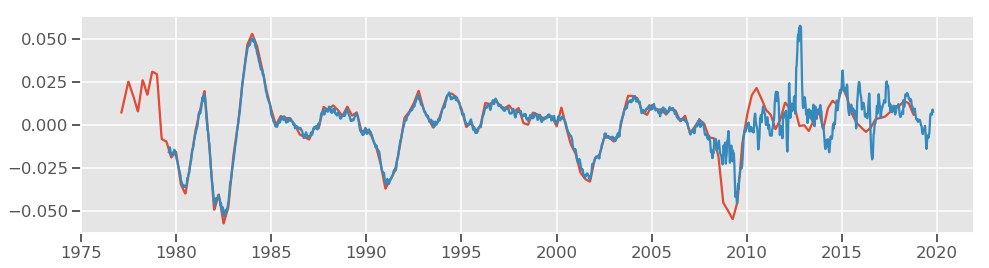

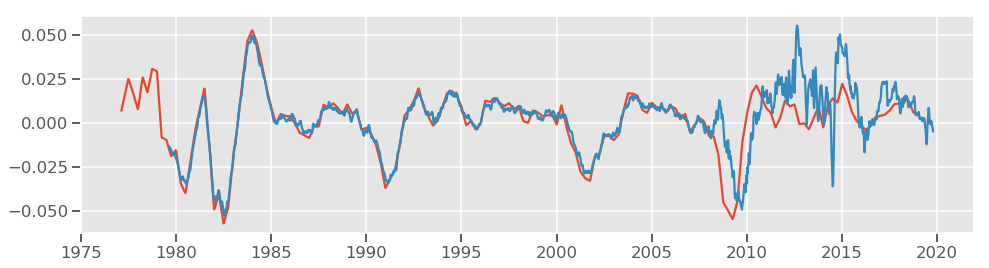

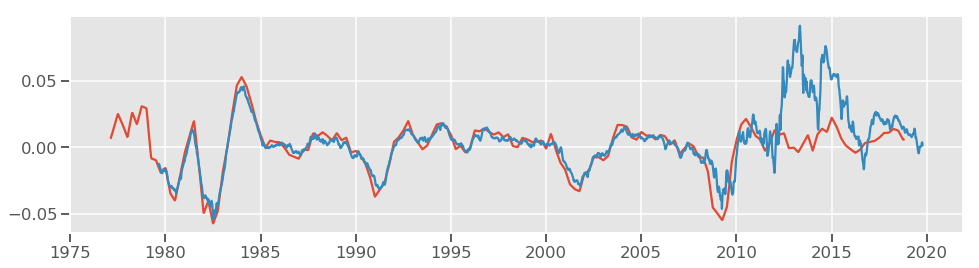

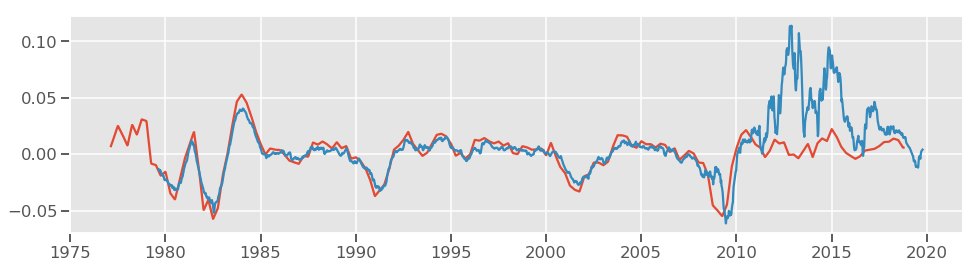

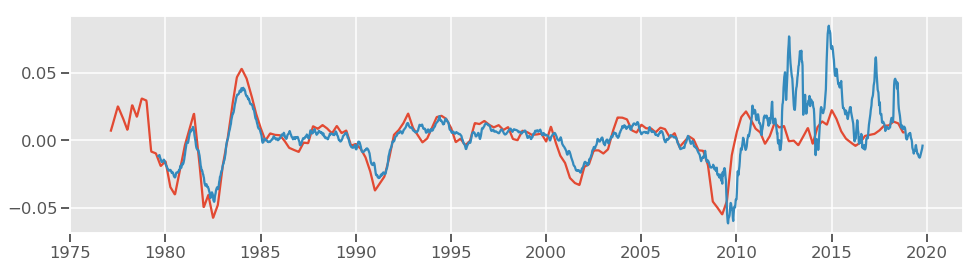

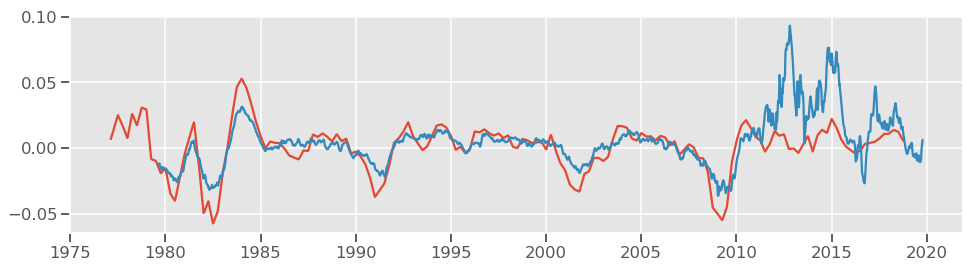

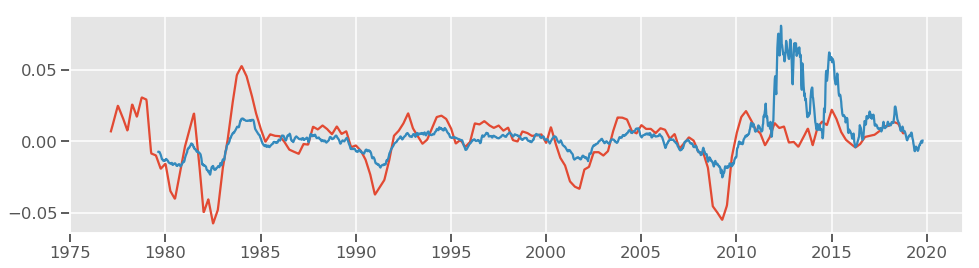

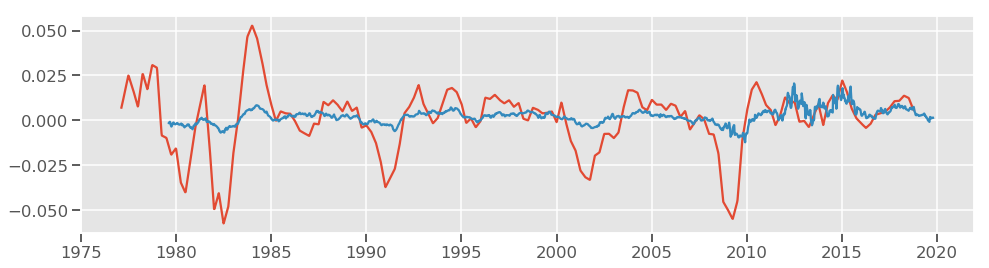

In [79]:
for key in pred_gap_df_dict.keys():
    fig = plt.figure(figsize=(16,4))
    pred_median = pd.DataFrame(pred_gap_df_dict[key].median(axis=1).shift(26))
    ax = plt.plot(df_merged.gap[X_scaled.index])
    ax = plt.plot(pred_median)

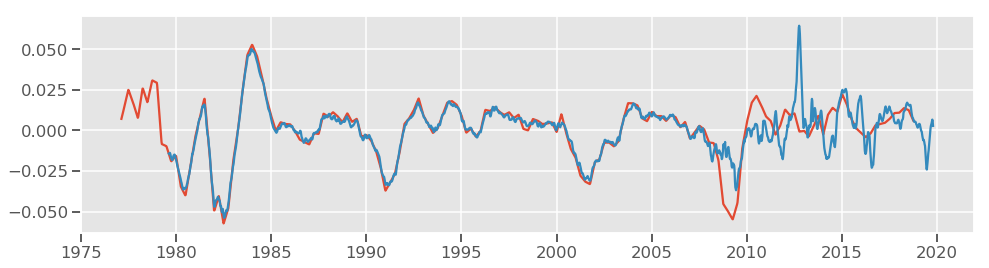

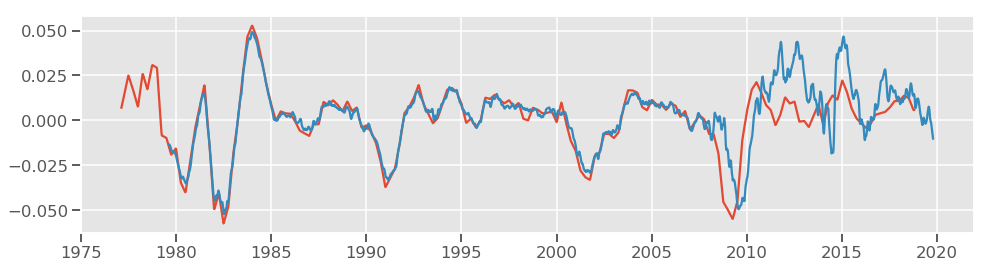

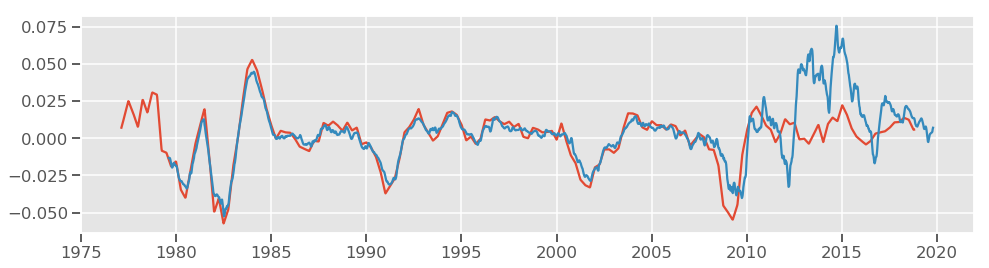

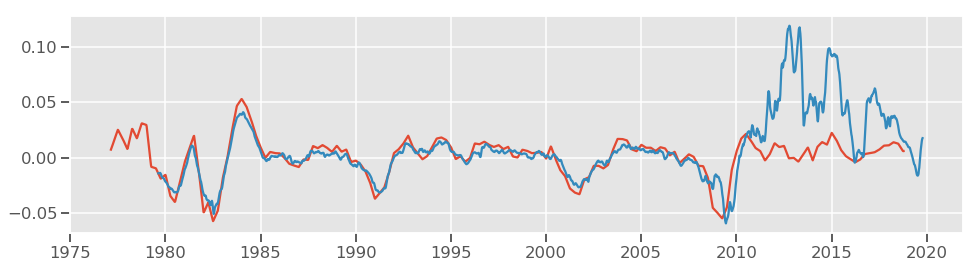

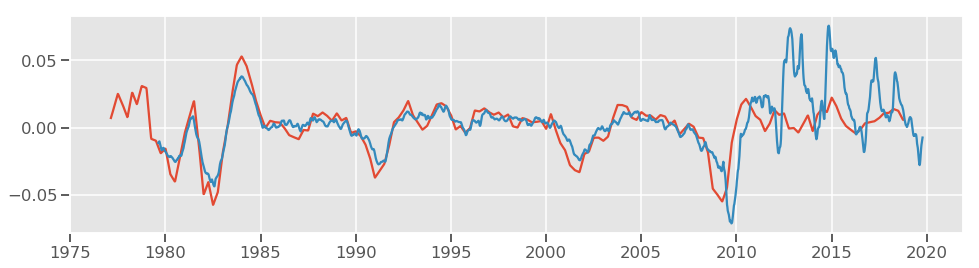

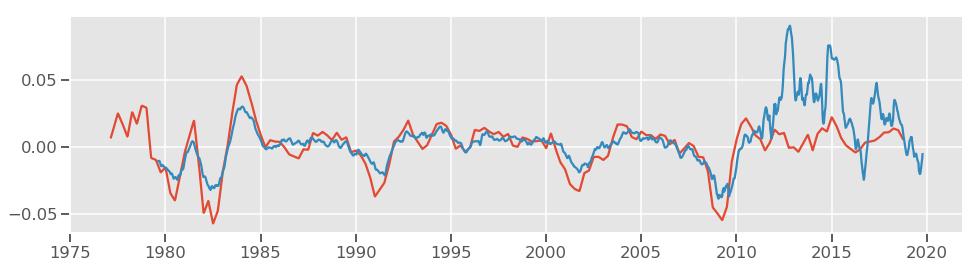

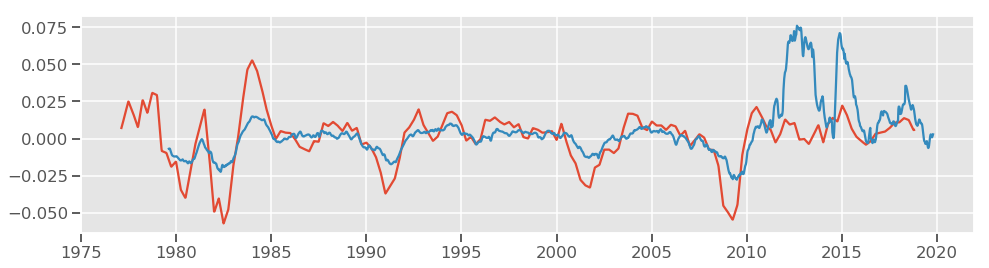

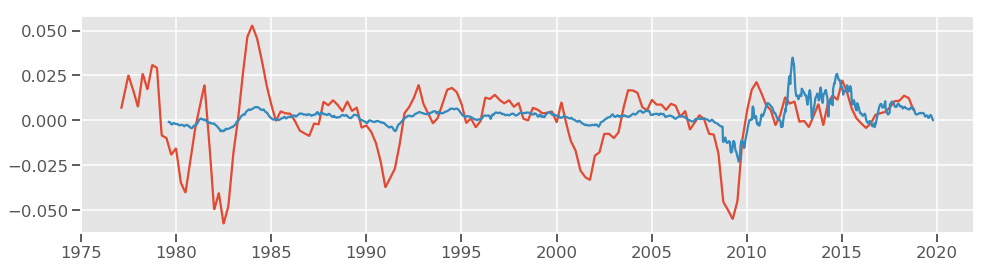

In [80]:
for key in pred_gap_df_dict.keys():
    fig = plt.figure(figsize=(16,4))
    pred_mean = pd.DataFrame(pred_gap_df_dict[key].mean(axis=1).shift(26))
    ax = plt.plot(df_merged.gap[X_scaled.index])
    ax = plt.plot(pred_mean)